# Memory models on Mixture of Markov Chains

## Data

$$
\begin{align*}
\texttt{markov chain} &\sim \mathrm{MarkovChains}(\texttt{n\_states}, \texttt{order})\\
(x_1, \ldots, x_l) &\sim \texttt{markov chain} \\
\mathcal{M} = \{x^{(1)}, \ldots, x^{(n_m)}\} &\sim \texttt{markov chain}
\end{align*}
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from tqdm.keras import TqdmCallback
from tqdm import trange, tqdm

import itertools
import sys;sys.path.append('..')
import utils

import tensorflow as tf
from tensorflow.keras import layers


/workspaces/hierarchical-attention-external-memory/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-14 03:03:57.688296: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 03:03:57.717570: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 03:03:57.718269: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 03:03:58.358494: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
n_states = 16
m = 2

state_tuples = list(itertools.product(range(n_states), repeat=m))

In [4]:
def generate_random_mc(n_states, m):
    state_tuples = list(itertools.product(range(n_states), repeat=m))

    transition_dict = dict()

    for state_tuple in state_tuples:
        next_state = np.random.randint(n_states)
        p = np.zeros(n_states)
        p[next_state] = 1

        transition_dict[state_tuple] = p

    return transition_dict

In [5]:
n_train_mcs = 10_000
n_test_mcs = 10_000
train_mcs = [generate_random_mc(n_states, m) for _ in trange(n_train_mcs)]
test_mcs = [generate_random_mc(n_states, m) for _ in trange(n_test_mcs)]

100%|██████████| 10000/10000 [00:07<00:00, 1313.70it/s]


In [6]:
def sample_markov_chain(transition_dict, prefix, num_steps):
    states_seq = prefix
    m = len(list(transition_dict.keys())[0])

    for i in range(num_steps-m):
        probabilities = transition_dict[tuple(states_seq[-m:])]
        next_state = np.random.choice(range(n_states), p=probabilities)
        states_seq.append(next_state)

    return states_seq

In [7]:
input_seq_len = 32 # length of input sequences
mem_seq_len = 5*m # length of each memory sequence
mem_size = 16 # number of memory sequences

n_train = 5_000
n_test = 2_500

def sample_mem_buffer(mem_seq_len, mem_size, transition_dict, input_seq=None, num_subseq_insertions=1):
    state_tuples = list(transition_dict.keys())
    mem_seqs = np.array([sample_markov_chain(
        transition_dict, prefix=list(state_tuples[np.random.choice(len(state_tuples))]), num_steps=mem_seq_len+1)
         for _ in range(mem_size)])

    mem_seqs_x = mem_seqs[:, :-1]
    mem_seqs_y = mem_seqs[:, 1:]

    if input_seq is not None:
        x_len = len(input_seq)
        for _ in range(num_subseq_insertions):
            start_idx = np.random.randint(0, x_len - mem_seq_len - 1)
            x_subseq = input_seq[start_idx:start_idx+mem_seq_len]
            y_subseq = input_seq[start_idx+1:start_idx+1+mem_seq_len]

            mem_seqs_x = np.concatenate([mem_seqs_x, np.expand_dims(x_subseq, axis=0)])
            mem_seqs_y = np.concatenate([mem_seqs_y, np.expand_dims(y_subseq, axis=0)])

    return mem_seqs_x, mem_seqs_y


def sample_seqs_dataset(n, input_seq_len, mem_seq_len, mem_size, markov_chains, num_subseq_insertions=1):

    # sample a Markov chain for each sample in the dataset
    transition_dicts = np.random.choice(markov_chains, n)

    # sample a sequence from each Markov chain
    seqs = np.array([sample_markov_chain(
        transition_dict, prefix=list(state_tuples[np.random.choice(len(state_tuples))]), num_steps=input_seq_len+1) for transition_dict in tqdm(transition_dicts, leave=False)])

    # create x and y sequences
    seqs_x = seqs[:, :-1]
    seqs_y = seqs[:, 1:]

    # sample memory buffers from each markov chain
    mem_seqs_x, mem_seqs_y = zip(
        *[sample_mem_buffer(mem_seq_len, mem_size, transition_dict, input_seq, num_subseq_insertions=num_subseq_insertions)
          for transition_dict, input_seq in tqdm(zip(transition_dicts, seqs), leave=False)])
    mem_seqs_x, mem_seqs_y = np.array(mem_seqs_x), np.array(mem_seqs_y)

    return seqs_x, seqs_y, mem_seqs_x, mem_seqs_y, transition_dicts


seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, sampled_train_mcs = sample_seqs_dataset(
    n_train, input_seq_len, mem_seq_len, mem_size, train_mcs, num_subseq_insertions=4)
seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, sampled_test_mcs = sample_seqs_dataset(
    n_test, input_seq_len, mem_seq_len, mem_size, test_mcs, num_subseq_insertions=4)


In [8]:
print(f'seqs_x_train.shape: {seqs_x_train.shape}; seqs_y_train.shape: {seqs_y_train.shape}') # shape [batch_size, seq_len]
print(f'mem_seqs_x_train.shape: {mem_seqs_x_train.shape}; mem_seqs_y.shape: {mem_seqs_y_train.shape}') # shape [batch_size, num_mem_seqs, mem_seq_len]

print(f'seqs_x_test.shape: {seqs_x_test.shape}; seqs_y_test.shape: {seqs_y_test.shape}') # shape [batch_size, seq_len]
print(f'mem_seqs_x_test.shape: {mem_seqs_x_test.shape}; mem_seqs_y_test.shape: {mem_seqs_y_test.shape}') # shape [batch_size, num_mem_seqs, mem_seq_len]

seqs_x_train.shape: (5000, 32); seqs_y_train.shape: (5000, 32)
mem_seqs_x_train.shape: (5000, 20, 10); mem_seqs_y.shape: (5000, 20, 10)
seqs_x_test.shape: (2500, 32); seqs_y_test.shape: (2500, 32)
mem_seqs_x_test.shape: (2500, 20, 10); mem_seqs_y_test.shape: (2500, 20, 10)


In [9]:
fit_kwargs = dict(epochs=30)

from tqdm.keras import TqdmCallback
from tqdm import tqdm
def create_callbacks():
    return [TqdmCallback(tqdm_class=tqdm)]


# Hierarchical Attention Model

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_train, mem_seqs_x_train, mem_seqs_y_train), seqs_y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test, mem_seqs_y_test), seqs_y_test)).batch(64)

In [10]:
from transformer_modules import AddPositionalEmbedding, create_positional_encoding, MemoryAddPositionalEmbedding
from transformer_modules import GlobalSelfAttention, CausalSelfAttention
from hierarchical_attention import MultiHeadHierarchicalAttention


class HierarchicalAttnMemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, symmetric_attention=False, **kwargs):
        super().__init__(**kwargs)
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        # self.self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        # self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')
        self.self_attention_layer = CausalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        if symmetric_attention:
            self.memory_self_attention_layer = self.self_attention_layer
        else:
            self.memory_self_attention_layer = GlobalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')

        # same attention layers for input and memories
        # self.self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='self_attn')
        # self.memory_self_attention_layer = self.self_attention_layer

        self.hierarchical_mem_attention = MultiHeadHierarchicalAttention(
            key_dim, value_dim=embedding_dim, symmetric_kernel=True, n_heads=n_heads,
            attn_scale_factor_per_seq=1, attn_scale_factor_over_seqs=1,
            dense_kwargs=dict(use_bias=False), name='mem_attn')

        self.output_dense = layers.Dense(vocab_size, name='output')

    def self_attention(self, seq):
        # return self.self_attention_layer(seq, seq, use_causal_mask=True)
        return self.self_attention_layer(seq)

    def memory_self_attention(self, mem_seqs):
        # lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=True)
        lambda_fn = lambda x: self.memory_self_attention_layer(x)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)

        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)

        retrieved_mems = self.hierarchical_mem_attention([embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs])

        logits = self.output_dense(retrieved_mems)

        return logits

In [11]:
vocab_size = n_states
embedding_dim = 64

hierattn_model = HierarchicalAttnMemoryModel(
    vocab_size, embedding_dim=embedding_dim, symmetric_attention=True,
    key_dim=embedding_dim//3, n_heads=3, name='memory_model')

hierattn_model(next(iter(train_ds))[0]); # build model

create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
hierattn_model.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
hierattn_model.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  1024      
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 causal_self_attention (Caus  multiple                 16509     
 alSelfAttention)                                                
                                                                 
 mem_attn (MultiHeadHierarch  multiple                 16320     
 icalAttention)                                       

100%|██████████| 10/10 [07:37<00:00, 45.77s/epoch, loss=0.277, accuracy=0.925, val_loss=0.289, val_accuracy=0.923]


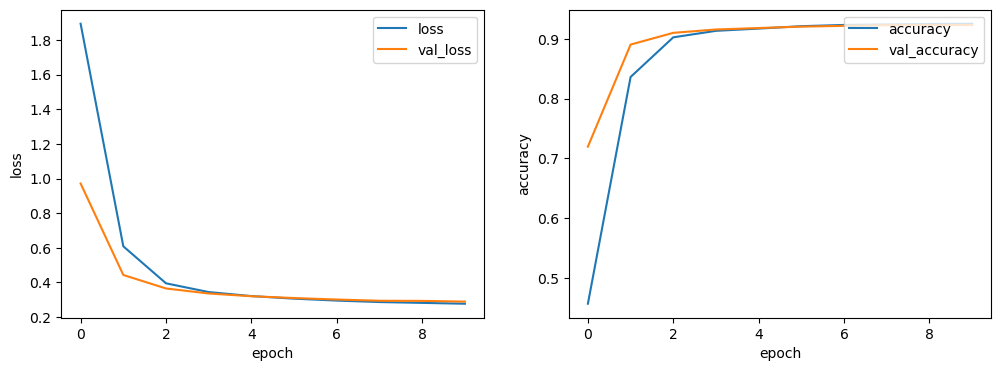

In [12]:
history = hierattn_model.fit(train_ds, validation_data=test_ds, verbose=0, callbacks=create_callbacks(), epochs=10)
utils.plot_history(history, plot_attrs=('loss', 'accuracy'), val=True, figsize=(12,4));

In [13]:
hierattn_model.evaluate(test_ds)

40/40 [==============================] - 9s 229ms/step - loss: 0.2893 - accuracy: 0.9230


[0.289341539144516, 0.9230499863624573]

40/40 [==============================] - 9s 190ms/step


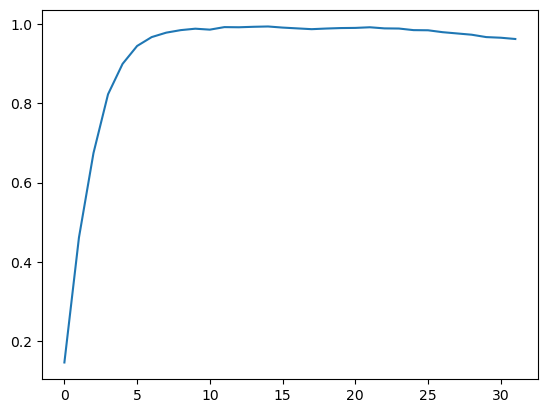

In [14]:
# plot accuracy as a function of position in sequence
preds = hierattn_model.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

In [15]:
# utilities for analyzing attention patterns in hierarchical attention model
import matplotlib.pyplot as plt
from matplotlib import gridspec


def plot_per_seq_attention(attn_, mem_seqs_x, train_seqs_x):
    num_mem_seqs = attn_.shape[0]
    fig = plt.figure(figsize=(num_mem_seqs*2,3))
    gs = gridspec.GridSpec(1, num_mem_seqs+1, width_ratios=[0.5]*num_mem_seqs+[0.1])
    axs = [fig.add_subplot(gs[i]) for i in range(num_mem_seqs)]
    cax = fig.add_subplot(gs[-1])
    im = None
    for t, ax in enumerate(axs):
        im = ax.imshow(attn_[t], cmap='gray', vmin=0, vmax=1)
        ax.set_xticks(range(len(mem_seqs_x[t])))
        ax.set_yticks(range(len(train_seqs_x)))
        ax.set_xticklabels(mem_seqs_x[t]);
        ax.set_yticklabels(train_seqs_x);
    fig.colorbar(im, cax=cax)
    axs[0].set_ylabel('input sequence')
    fig.supxlabel('memory sequences', y=0.)
    fig.suptitle('attention within each memory sequence')
    return fig

def plot_seq_attention(attn_, mem_seqs_x, train_seqs_x, **figkwargs):

    fig, ax = plt.subplots(figsize=(len(train_seqs_x), len(mem_seqs_x)))
    cmap = 'gray' if attn_.shape[-1] == 1 else None
    im = ax.imshow(attn_, cmap='gray', vmin=0, vmax=1)
    ax.set_yticks(range(len(mem_seqs_x)))
    ax.set_xticks(range(len(train_seqs_x)))
    ax.set_yticklabels([tuple(x) for x in mem_seqs_x]);
    ax.set_xticklabels(train_seqs_x);

    ax.set_xlabel('input sequence')
    ax.set_ylabel('memory sequences')
    ax.set_title('attention over sequences')

    fig.colorbar(im, ax=ax);
    return fig


def plot_attention_hierarchical(sample_input_index, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model):
    """
    choose sample input and plot the attention associated to the argmax probability vocab at each input position 
    (memory_seq versus each input element), call plot_seq_attention as subfunction
    """
    b = sample_input_index
    sample_input = seqs_x_train[b:b+1]
    print("sample_input: ",sample_input)
    sample_mem_seq_x = mem_seqs_x_train[b:b+1]
    sample_mem_seq_y = mem_seqs_y_train[b:b+1]

    pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
    pred = np.argmax(pred, axis=-1)
    print(f'prediction: {pred[0]}')
    print(f'y: {seqs_y_train[b]}')
    print(pred[0] == seqs_y_train[b])
    attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

    fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])
    attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]
    plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

sample_input:  [[ 6  9  7  2  4 11  6  5  0  2 12  3  5  3  4  9  5 15  7 10  1  7  3  5
   3  4  9  5 15  7 10  1]]
prediction: [11  7  6  4 11  6  5  0  2 12  3  5  3  4  9  5 15  7 10  1  7  3  5  3
  4  9  5 15  7 10  1  7]
y: [ 9  7  2  4 11  6  5  0  2 12  3  5  3  4  9  5 15  7 10  1  7  3  5  3
  4  9  5 15  7 10  1  7]
[False  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


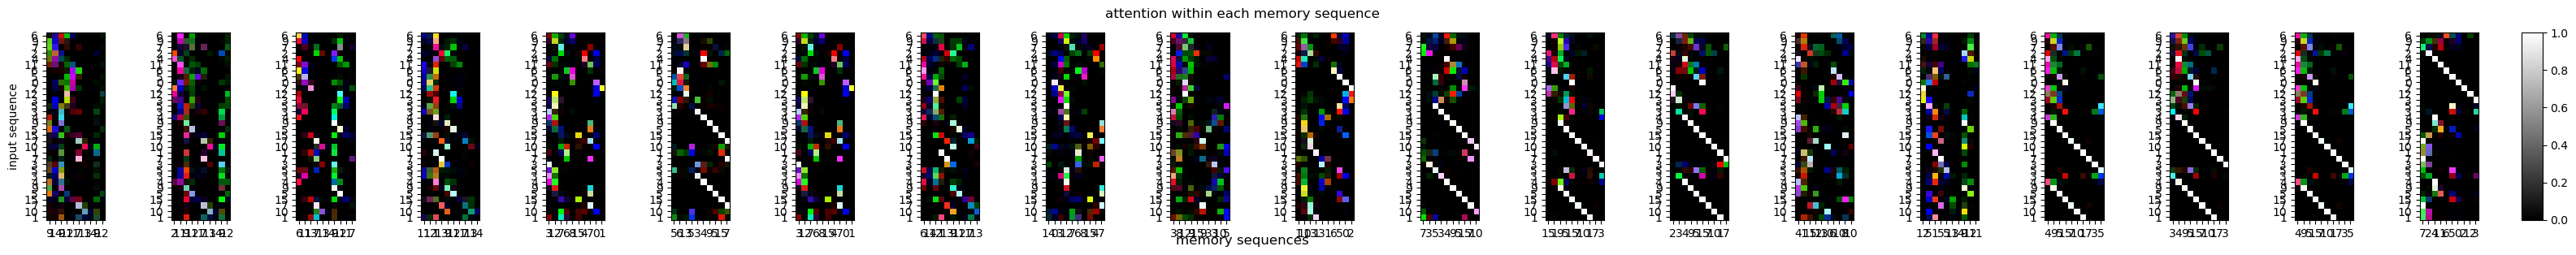

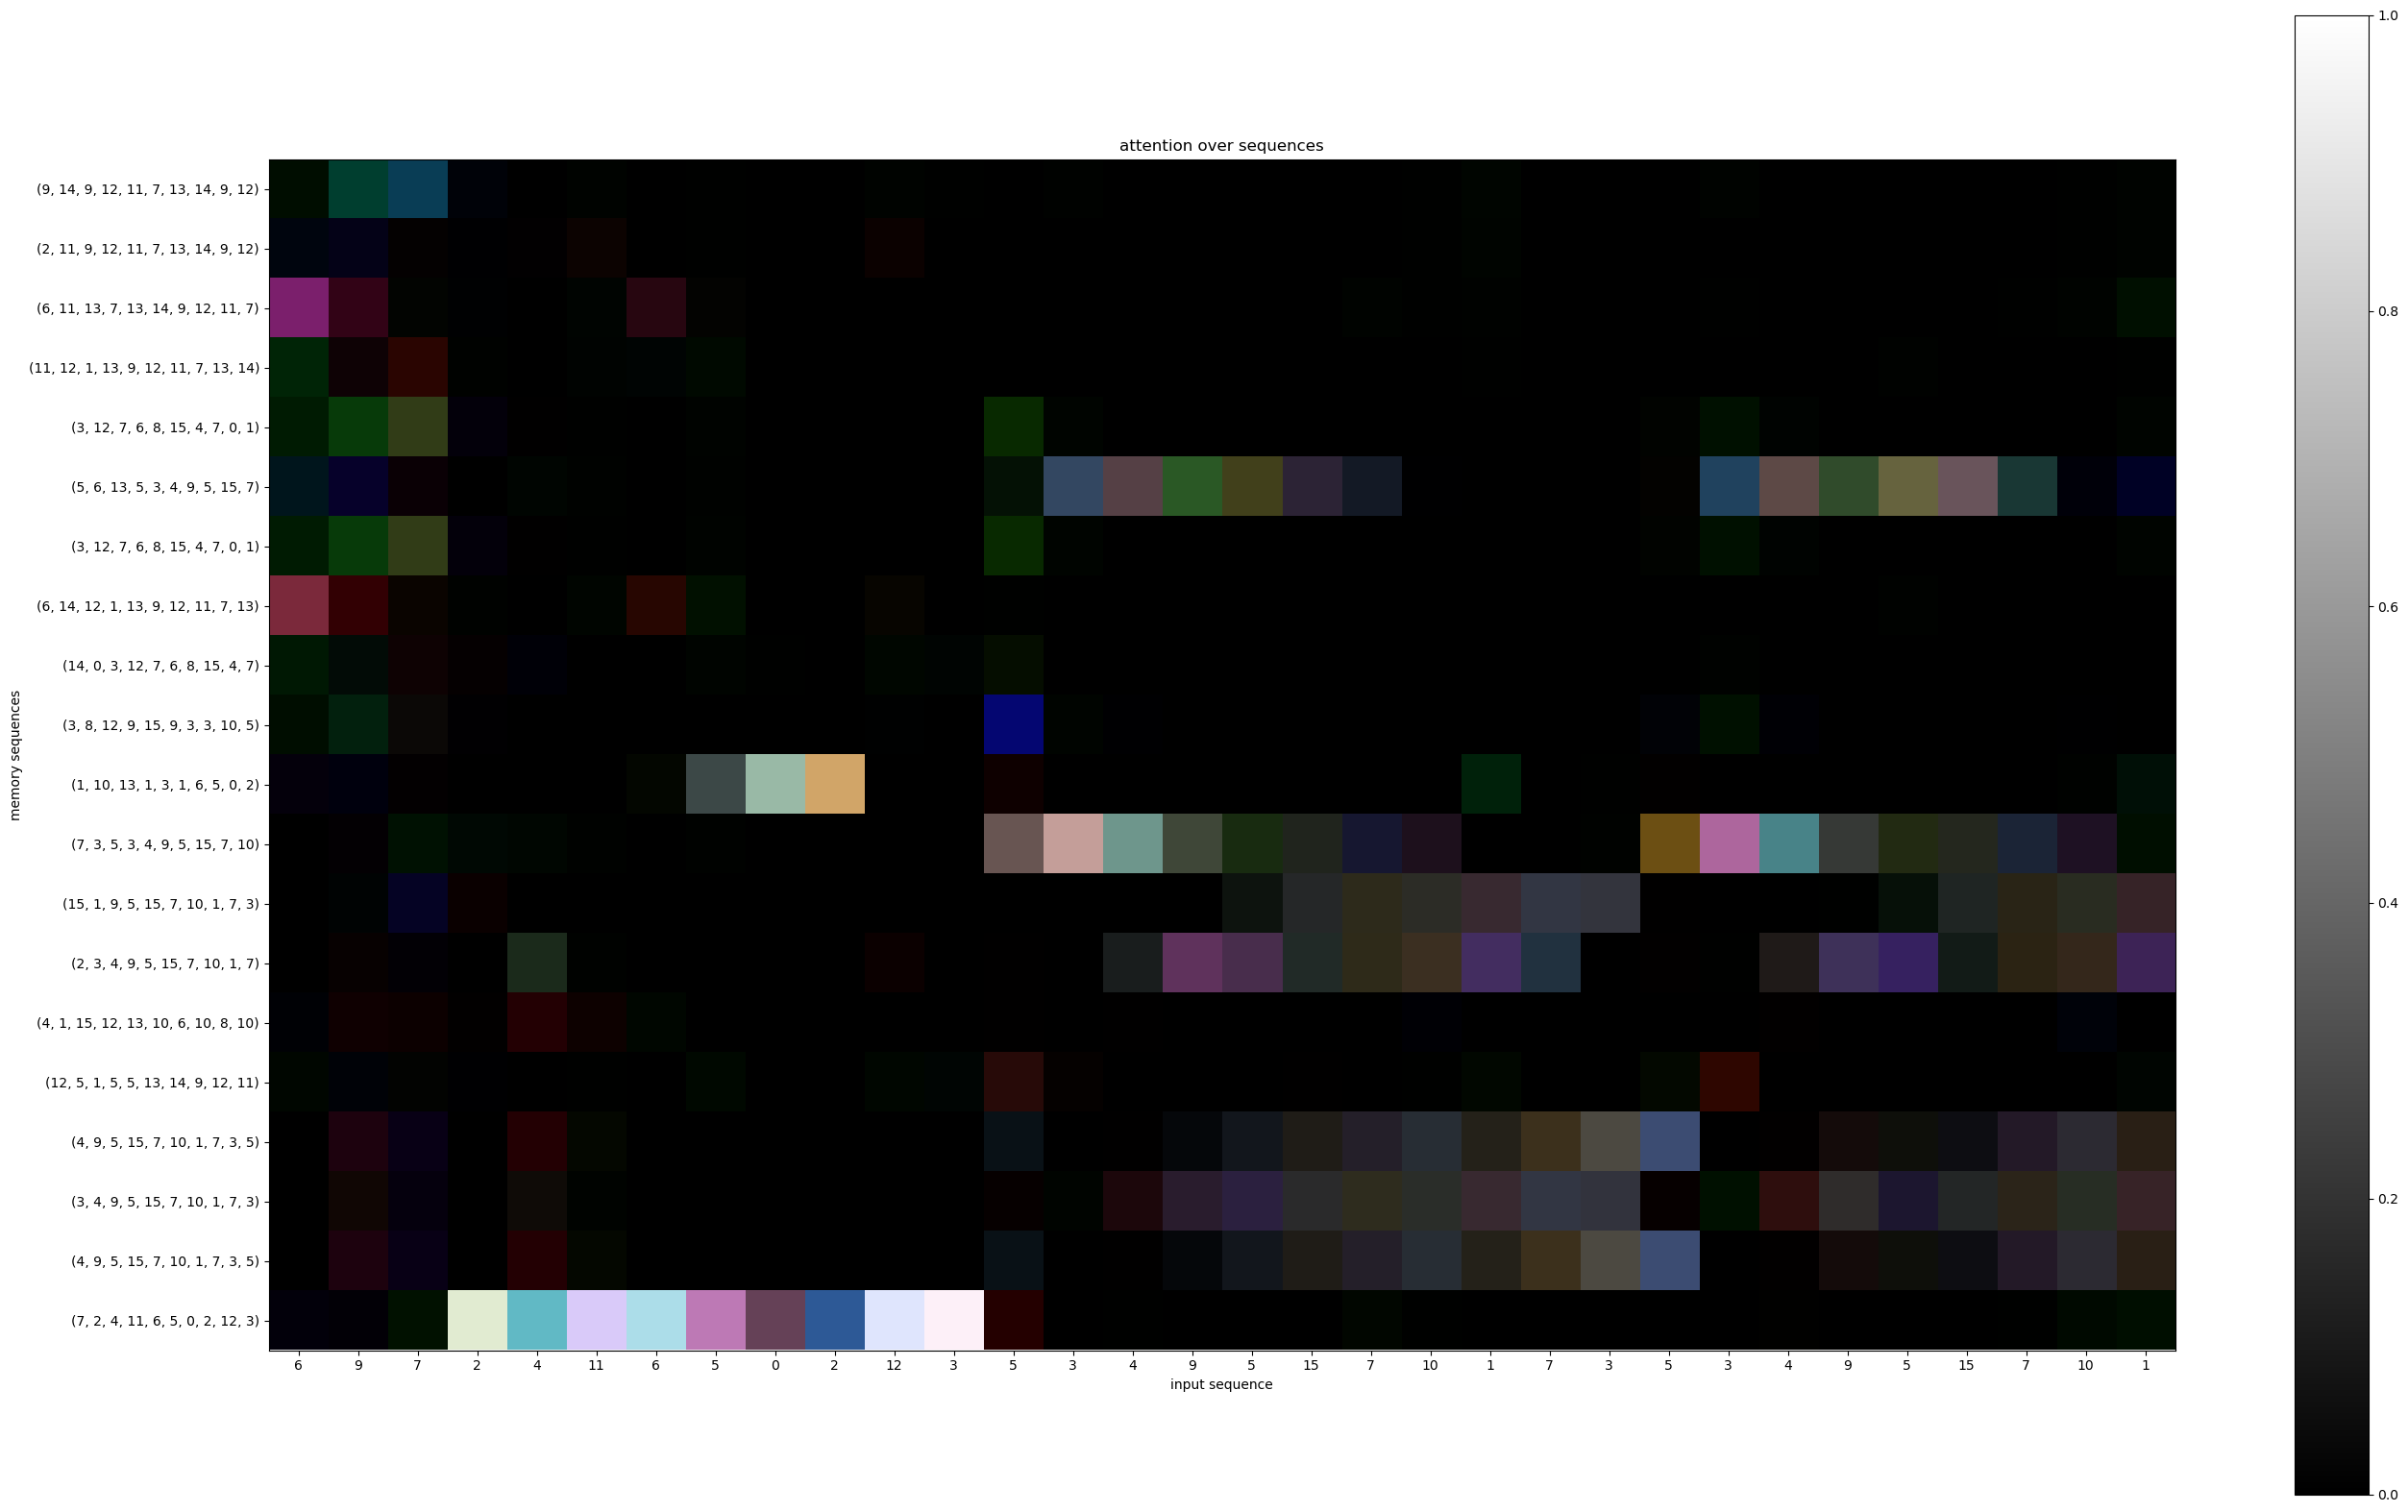

In [16]:
idx = np.random.choice(len(seqs_x_test))

plot_attention_hierarchical(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, hierattn_model)

100%|██████████| 6/6 [00:23<00:00,  3.92s/it]


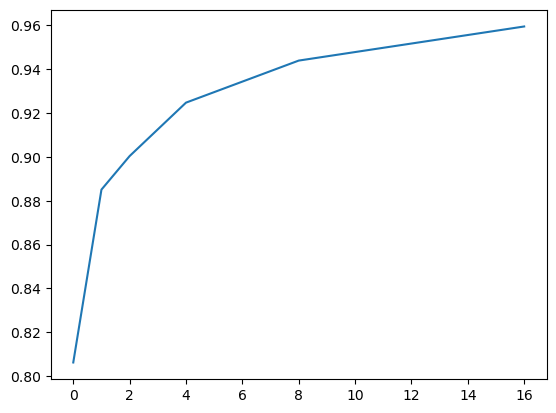

In [28]:
accs = []
nums_subseqs = [0, 1, 2, 4, 8, 16]
for num_subseqs in tqdm(nums_subseqs):
    seqs_x_test_, seqs_y_test_, mem_seqs_x_test_, mem_seqs_y_test_, sampled_test_mcs_ = sample_seqs_dataset(
        500, input_seq_len, mem_seq_len, mem_size, train_mcs, num_subseq_insertions=num_subseqs)

    test_ds_ = tf.data.Dataset.from_tensor_slices(((seqs_x_test_, mem_seqs_x_test_, mem_seqs_y_test_), seqs_y_test_)).batch(64)
    _, acc = hierattn_model.evaluate(test_ds_, verbose=0)
    accs.append(acc)

plt.plot(nums_subseqs, accs)

## Kernel Model

In [17]:
import tensorflow as tf
from tensorflow.keras import layers
from transformer_modules import AddPositionalEmbedding, MemoryAddPositionalEmbedding
from custom_attention import GlobalSelfAttention, CausalSelfAttention, CrossAttention

class KernelMemoryTransformer(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, ff_sizes, symmetric_attention=False, **kwargs):
        super().__init__(**kwargs)

        self.symmetric_attention = symmetric_attention
        self.alpha_it = None
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different self-attention layers for input and memories for encoding sequences
        self.input_self_attention = CausalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        if symmetric_attention:
            self.memory_self_attention_layer = self.input_self_attention
        else:
            self.memory_self_attention_layer = GlobalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')

        # create cross attention layer
        self.cross_attention_layer = CrossAttention(num_heads=n_heads, key_dim=key_dim, symmetric_attention=symmetric_attention, name='cross_attn')

        self.feedforward = tf.keras.Sequential([layers.Dense(z, activation='relu') for z in ff_sizes], name='feedforward')
        self.output_dense = layers.Dense(vocab_size, activation='softmax', name='output')

    def memory_self_attention(self, mem_seqs):
        '''apply self-attention to each memory sequence'''
        lambda_fn = lambda x: self.memory_self_attention_layer(x)
        return tf.map_fn(lambda_fn, mem_seqs)

    def get_cross_probs(self, embedded_input_seqs, embedded_mem_x_seqs):
        '''compute cross attention probabilities prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory'''

        def get_memory_cross_probs(Et):
            cross_attention_output = self.cross_attention_layer(
                x=embedded_input_seqs,
                context=Et)
            return cross_attention_output # shape: (batch_size, seq_len, mem_len)

        # compute cross-attention for each memory
        cross_probs = tf.map_fn(get_memory_cross_probs, tf.transpose(embedded_mem_x_seqs, perm=[1, 0, 2, 3]))
        cross_probs = tf.transpose(cross_probs, perm=[1, 0, 2, 3]) # shape: (batch_size, n_mem, mem_length, embedding_dim)

        # compute cross-probs from cross-attention via feedforward network
        cross_probs = self.feedforward(cross_probs)
        cross_probs = self.output_dense(cross_probs) # shape: (batch_size, n_mems, mem_length, vocab_size)

        return cross_probs

    def get_observed_cross_probs(self, cross_probs, seq_input):
        '''given the cross_probs tensor, extract the components coresponding to the observed sequence'''

        cross_probs_observed = tf.transpose(cross_probs, perm=(1,0,2,3))
        cross_probs_observed = tf.map_fn(lambda x: tf.gather(x, indices=seq_input, axis=-1, batch_dims=2), cross_probs_observed)
        cross_probs_observed = tf.transpose(cross_probs_observed, perm=(1,0,2))
        return cross_probs_observed

    def compute_mem_attention_scores(self, cross_probs_observed):
        '''compute memory-level attention scores, alpha_it (i is position in input sequence, t is memory index)'''

        log_cross_probs_observed = tf.math.log(cross_probs_observed)
        w_it = tf.math.cumsum(log_cross_probs_observed, axis=-1, exclusive=True)
        alpha_it = tf.nn.softmax(w_it, axis=1) # shape [batch_size, num_mems, in_seq_length]
        return alpha_it

    def call(self, inputs):
        seq_input, memory_input = inputs

        # embed input sequences and memory sequences
        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_input)

        # add positional embeddings
        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)

        # encode via self-attention
        embedded_input_seqs = self.input_self_attention(embedded_input_seqs) # shape: (batch_size, input_length, embedding_dim)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs) # shape: (batch_size, num_memories, memory_length, embedding_dim)

        # compute prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory
        cross_probs = self.get_cross_probs(embedded_input_seqs, embedded_mem_x_seqs)

        # compute prob(x_{i+1} | x_{1:i}, x^{(t)}) for each memory
        cross_probs_observed = self.get_observed_cross_probs(cross_probs, seq_input)

        # compute alpha_it = softmax(w_it) where w_it = sum_{j=1}^{i-1} log prob(x_{j+1} | x_{1:j}, x^{(t)})
        alpha_it = self.compute_mem_attention_scores(cross_probs_observed)
        self.alpha_it = alpha_it

        # compute prob(x_{i+1} | x_{1:i}, {x^{(t)}}_t) = \sum_t alpha_it * prob(x_{i+1} = . | x_{1:i}, x^{(t)})
        output = tf.reduce_sum(tf.multiply(tf.expand_dims(alpha_it, axis=-1), cross_probs), axis=1)

        return output

In [18]:
train_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_train, mem_seqs_x_train), seqs_y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test), seqs_y_test)).batch(64)

vocab_size = len(state_tuples)
embedding_dim = 64
kernel_model = KernelMemoryTransformer(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, ff_sizes = [vocab_size//2,], name='kernel_memory_model')

kernel_model([seqs_x_train[:64], mem_seqs_x_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
kernel_model.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
kernel_model.summary()


Model: "kernel_memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  16384     
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 causal_self_attention_1 (Ca  multiple                 12608     
 usalSelfAttention)                                              
                                                                 
 global_self_attention (Glob  multiple                 12608     
 alSelfAttention)                              

100%|██████████| 10/10 [22:21<00:00, 134.20s/epoch, loss=1.65, accuracy=0.528, val_loss=1.69, val_accuracy=0.512]


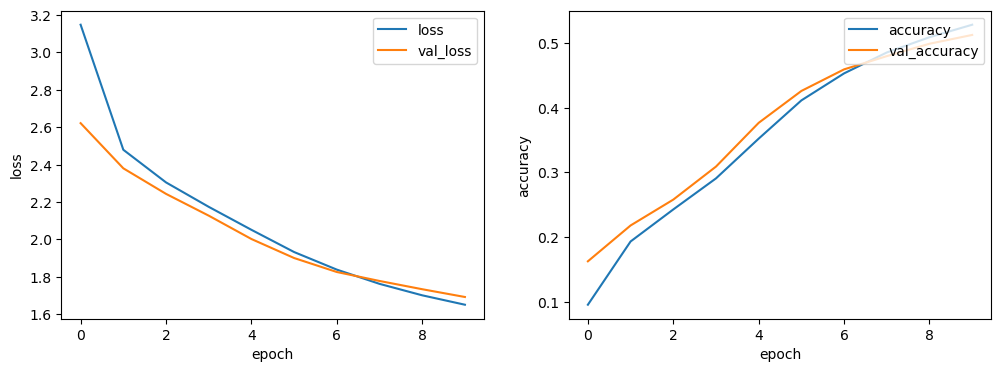

In [19]:
history = kernel_model.fit(train_ds, validation_data=test_ds, verbose=0, callbacks=create_callbacks(), epochs=10)
utils.plot_history(history, plot_attrs=('loss', 'accuracy'), val=True, figsize=(12,4));

In [20]:
kernel_model.evaluate(train_ds)

79/79 [==============================] - 39s 487ms/step - loss: 1.6146 - accuracy: 0.5389


[1.61460280418396, 0.5389062762260437]

In [21]:
kernel_model.evaluate(test_ds)

40/40 [==============================] - 20s 503ms/step - loss: 1.6917 - accuracy: 0.5121


[1.691650152206421, 0.5121250152587891]

40/40 [==============================] - 21s 470ms/step


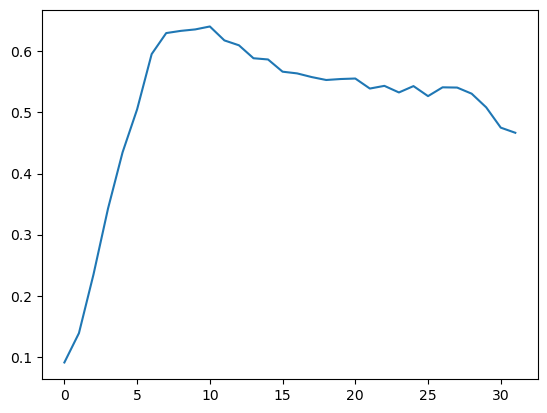

In [22]:
# plot accuracy as a function of position in sequence
preds = kernel_model.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

sample_input:  [[11 14  8  3  5  8 15  2  4 13 10  2  9 11 12 12  1 13  2  8  1  7 11  2
   1 11  2  1 11  2  1 11]]
prediction: [13 13  3  5  8 15  2  4 13 10  2 12 11 12  2  1 13 11 12 10 10  2  2  1
  7  7  7  7  2  1 11  2]
y: [14  8  3  5  8 15  2  4 13 10  2  9 11 12 12  1 13  2  8  1  7 11  2  1
 11  2  1 11  2  1 11  2]
[False False  True  True  True  True  True  True  True  True  True False
  True  True False  True  True False False False False False  True  True
 False False False False  True  True  True  True]


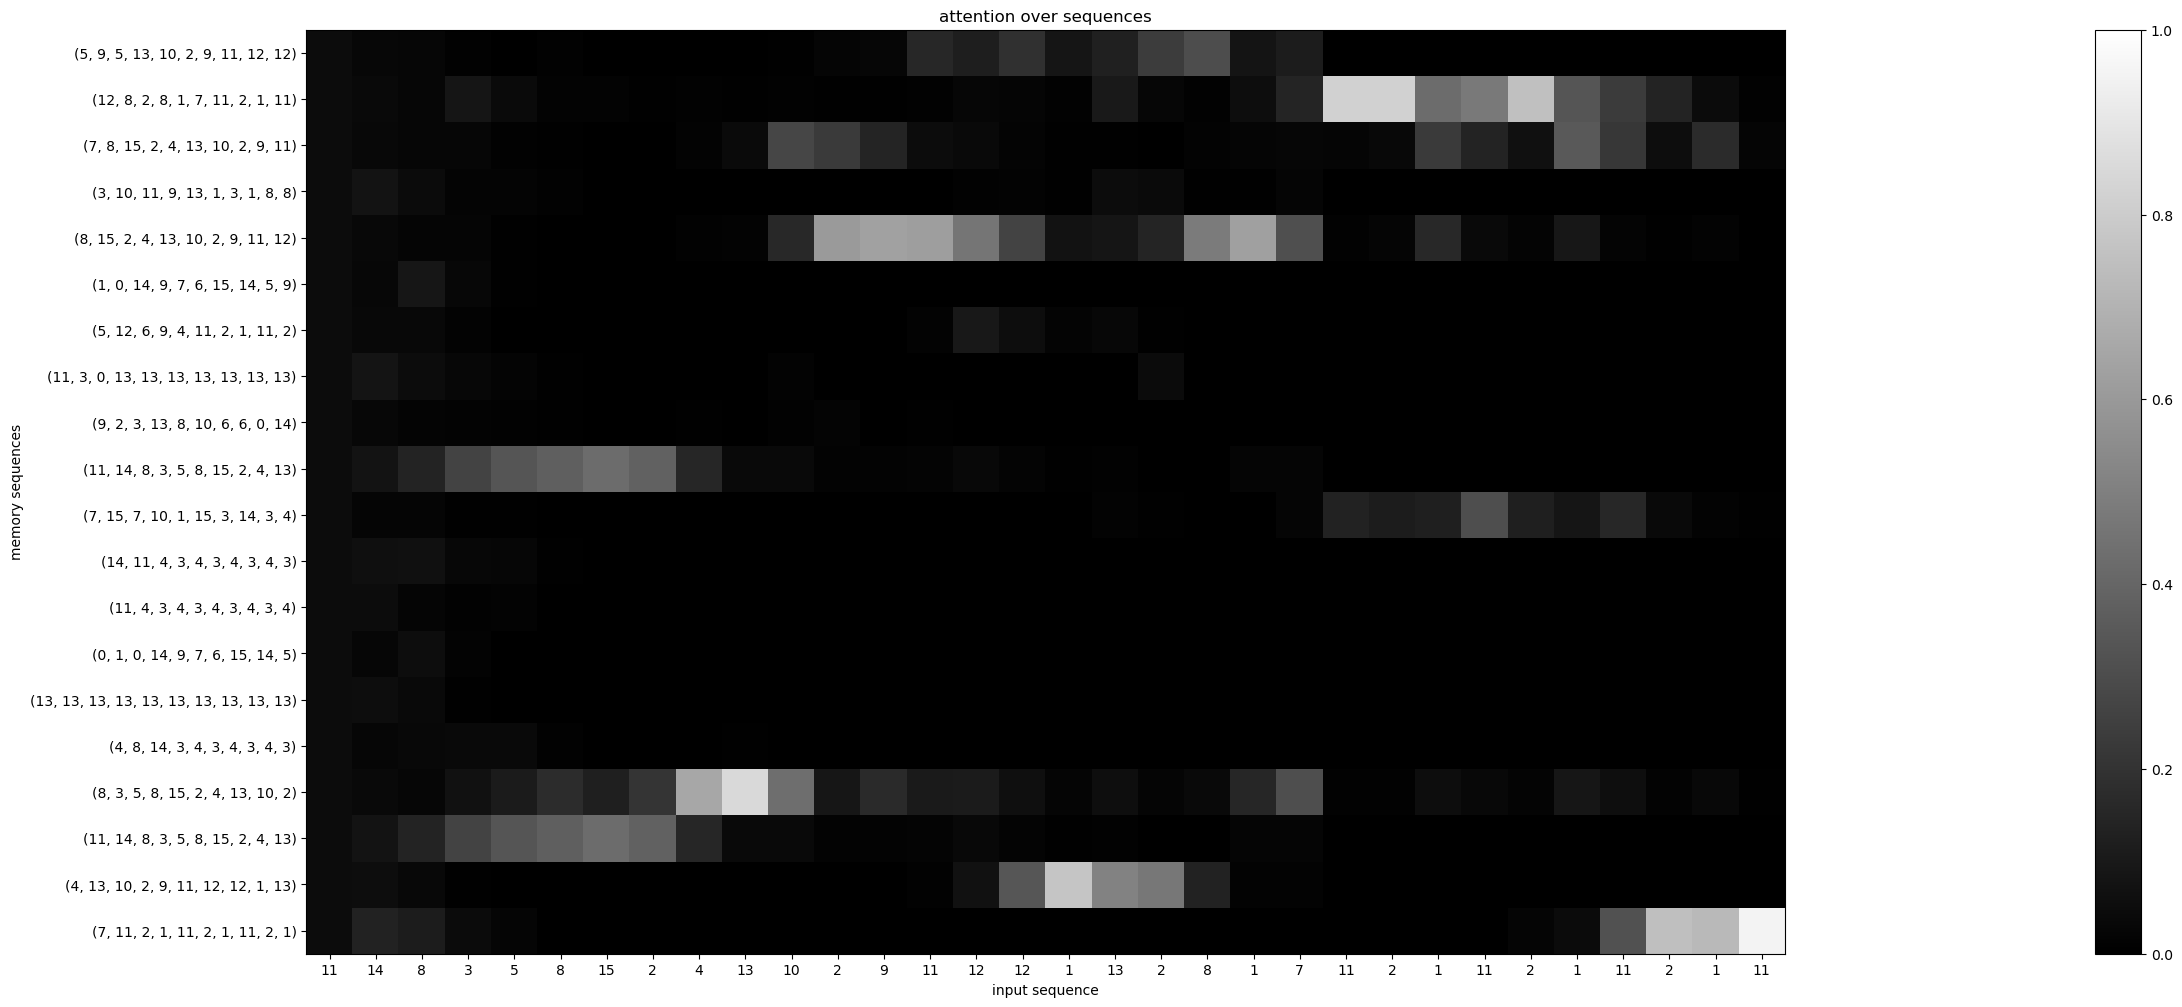

In [29]:
from kernel_model_experiments.utils_kernel_transformer import plot_attention
idx = np.random.choice(len(seqs_x_test))
plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, kernel_model)

100%|██████████| 6/6 [00:36<00:00,  6.14s/it]


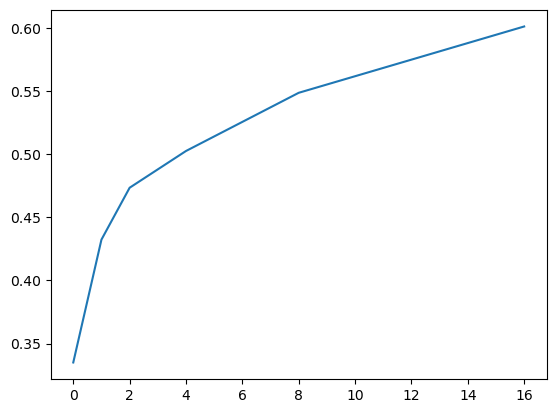

In [26]:
accs = []
nums_subseqs = [0, 1, 2, 4, 8, 16]
for num_subseqs in tqdm(nums_subseqs):
    seqs_x_test_, seqs_y_test_, mem_seqs_x_test_, mem_seqs_y_test_, sampled_test_mcs_ = sample_seqs_dataset(
        500, input_seq_len, mem_seq_len, mem_size, train_mcs, num_subseq_insertions=num_subseqs)

    test_ds_ = tf.data.Dataset.from_tensor_slices(((seqs_x_test_, mem_seqs_x_test_), seqs_y_test_)).batch(64)
    _, acc = kernel_model.evaluate(test_ds_, verbose=0)
    accs.append(acc)

plt.plot(nums_subseqs, accs)

## Kernel Model with symmetric and crossAttn value = shifted memory option added

### plot utils

In [10]:
def plot_seq_attention(attn_, mem_seqs_x, train_seqs_x, title):
    num_mem_seqs = attn_.shape[0]
    fig, ax = plt.subplots(figsize=(num_mem_seqs*4,12))
    im = ax.imshow(attn_, cmap='gray', vmin=0, vmax=1)
    ax.set_yticks(range(len(mem_seqs_x)))
    ax.set_xticks(range(len(train_seqs_x)))
    ax.set_yticklabels([tuple(x) for x in mem_seqs_x]);
    ax.set_xticklabels(train_seqs_x);

    ax.set_xlabel('input sequence')
    ax.set_ylabel('memory sequences')
    ax.set_title(title)

    fig.colorbar(im, ax=ax)
    
    
def plot_attention(sample_input_index, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model):
    """
    choose sample input and plot the attention associated to the argmax probability vocab at each input position 
    (memory_seq versus each input element), call plot_seq_attention as subfunction
    """
    b = sample_input_index
    sample_input = seqs_x_train[b:b+1]
    print("sample_input: ",sample_input)
    sample_mem_seq_x = mem_seqs_x_train[b:b+1]
    sample_mem_seq_y = mem_seqs_y_train[b:b+1]

    pred = memory_model([sample_input, sample_mem_seq_x])
    pred = np.argmax(pred, axis=-1)
    print(f'prediction: {pred[0]}')
    print(f'y: {seqs_y_train[b]}')
    print(pred[0] == seqs_y_train[b])
    cross_probs_observed = memory_model.cross_probs_observed[0]
    attn_ = memory_model.alpha_it[0]
    plot_seq_attention(cross_probs_observed, sample_mem_seq_x[0], sample_input[0], "probability of predicting the next observed token given previous input and memory x^(t)")
    plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0], "alpha_it attention")
    
def plot_cross_prob_observed_and_attn_crossAttn_y(sample_input_index, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model):
    """
    choose sample input and plot the attention associated to the argmax probability vocab at each input position 
    (memory_seq versus each input element), call plot_seq_attention as subfunction
    """
    b = sample_input_index
    sample_input = seqs_x_train[b:b+1]
    print("sample_input: ",sample_input)
    sample_mem_seq_x = mem_seqs_x_train[b:b+1]
    sample_mem_seq_y = mem_seqs_y_train[b:b+1]

    pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
    pred = np.argmax(pred, axis=-1)
    print(f'prediction: {pred[0]}')
    print(f'y: {seqs_y_train[b]}')
    print(pred[0] == seqs_y_train[b])
    cross_probs_observed = memory_model.cross_probs_observed[0]
    attn_ = memory_model.alpha_it[0]
    plot_seq_attention(cross_probs_observed, sample_mem_seq_x[0], sample_input[0], "probability of predicting the next observed token given previous input and memory x^(t)")
    plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0], "alpha_it attention")
    

### crossAttn Value = Shifted memory & Quasi-Symmetric Kernel

In [11]:
from kernel_memory_transformer import KernelMemoryTransformer

train_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_train, mem_seqs_x_train, mem_seqs_y_train), seqs_y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test, mem_seqs_y_test), seqs_y_test)).batch(64)

In [12]:
vocab_size = n_states
embedding_dim = 64
kernel_model_cross_y = KernelMemoryTransformer(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, ff_sizes = [vocab_size//2,], symmetric_attention = True, crossAttn_value_shifted = True, name='kernel_model_cross_y')


kernel_model_cross_y([seqs_x_train[:64], mem_seqs_x_train[:64], mem_seqs_y_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
kernel_model_cross_y.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
kernel_model_cross_y.summary()

Model: "kernel_model_cross_y"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  1024      
                                                                 
 pos_embedder_adder (AddPos  multiple                  0         
 itionalEmbedding)                                               
                                                                 
 mem_pos_embedder_adder (Me  multiple                  0         
 moryAddPositionalEmbedding                                      
 )                                                               
                                                                 
 causal_self_attention (Cau  multiple                  12608     
 salSelfAttention)                                               
                                                                 
 cross_attention (CrossAtte  multiple         

  0%|          | 0/30 [00:00<?, ?epoch/s]

Instructions for updating:
Use fn_output_signature instead


100%|██████████| 30/30 [07:08<00:00, 14.28s/epoch, loss=0.996, accuracy=0.746, val_loss=1.15, val_accuracy=0.71] 


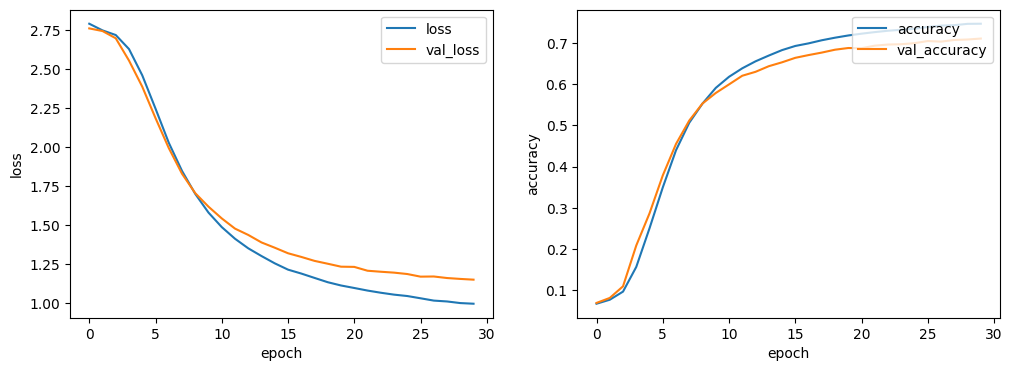

In [13]:
history2 = kernel_model_cross_y.fit(train_ds, validation_data=test_ds, verbose=0, callbacks=create_callbacks(), **fit_kwargs)
utils.plot_history(history2, plot_attrs=('loss', 'accuracy'), val=True, figsize=(12,4));

40/40 [==============================] - 3s 44ms/step


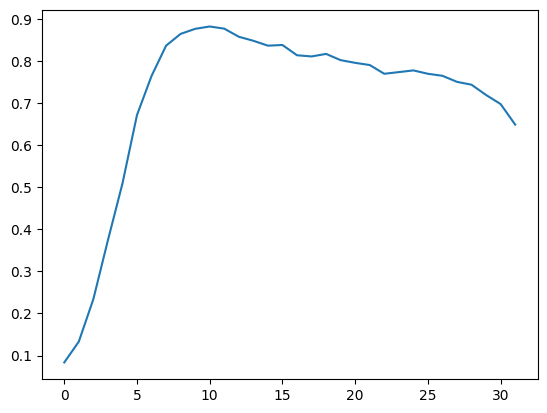

In [14]:
# plot accuracy as a function of position in sequence
preds = kernel_model_cross_y.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

kernel_model_cross_y
sample_input:  [[12  3  3  7  1  0 13 13  9  1  8 13  3  4  0  2 13 14  8  3  4  0  2 13
  14  8  3  4  0  2 13 14]]
prediction: [15  8  7  1 12 13 13  9  1  8 13  3  4  0  2 13 14 13 13  4  0  2 13 14
 13  3  1  1 13 13  9 13]
y: [ 3  3  7  1  0 13 13  9  1  8 13  3  4  0  2 13 14  8  3  4  0  2 13 14
  8  3  4  0  2 13 14  8]
[False False  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True False False  True  True  True  True  True
 False  True False False False  True False False]


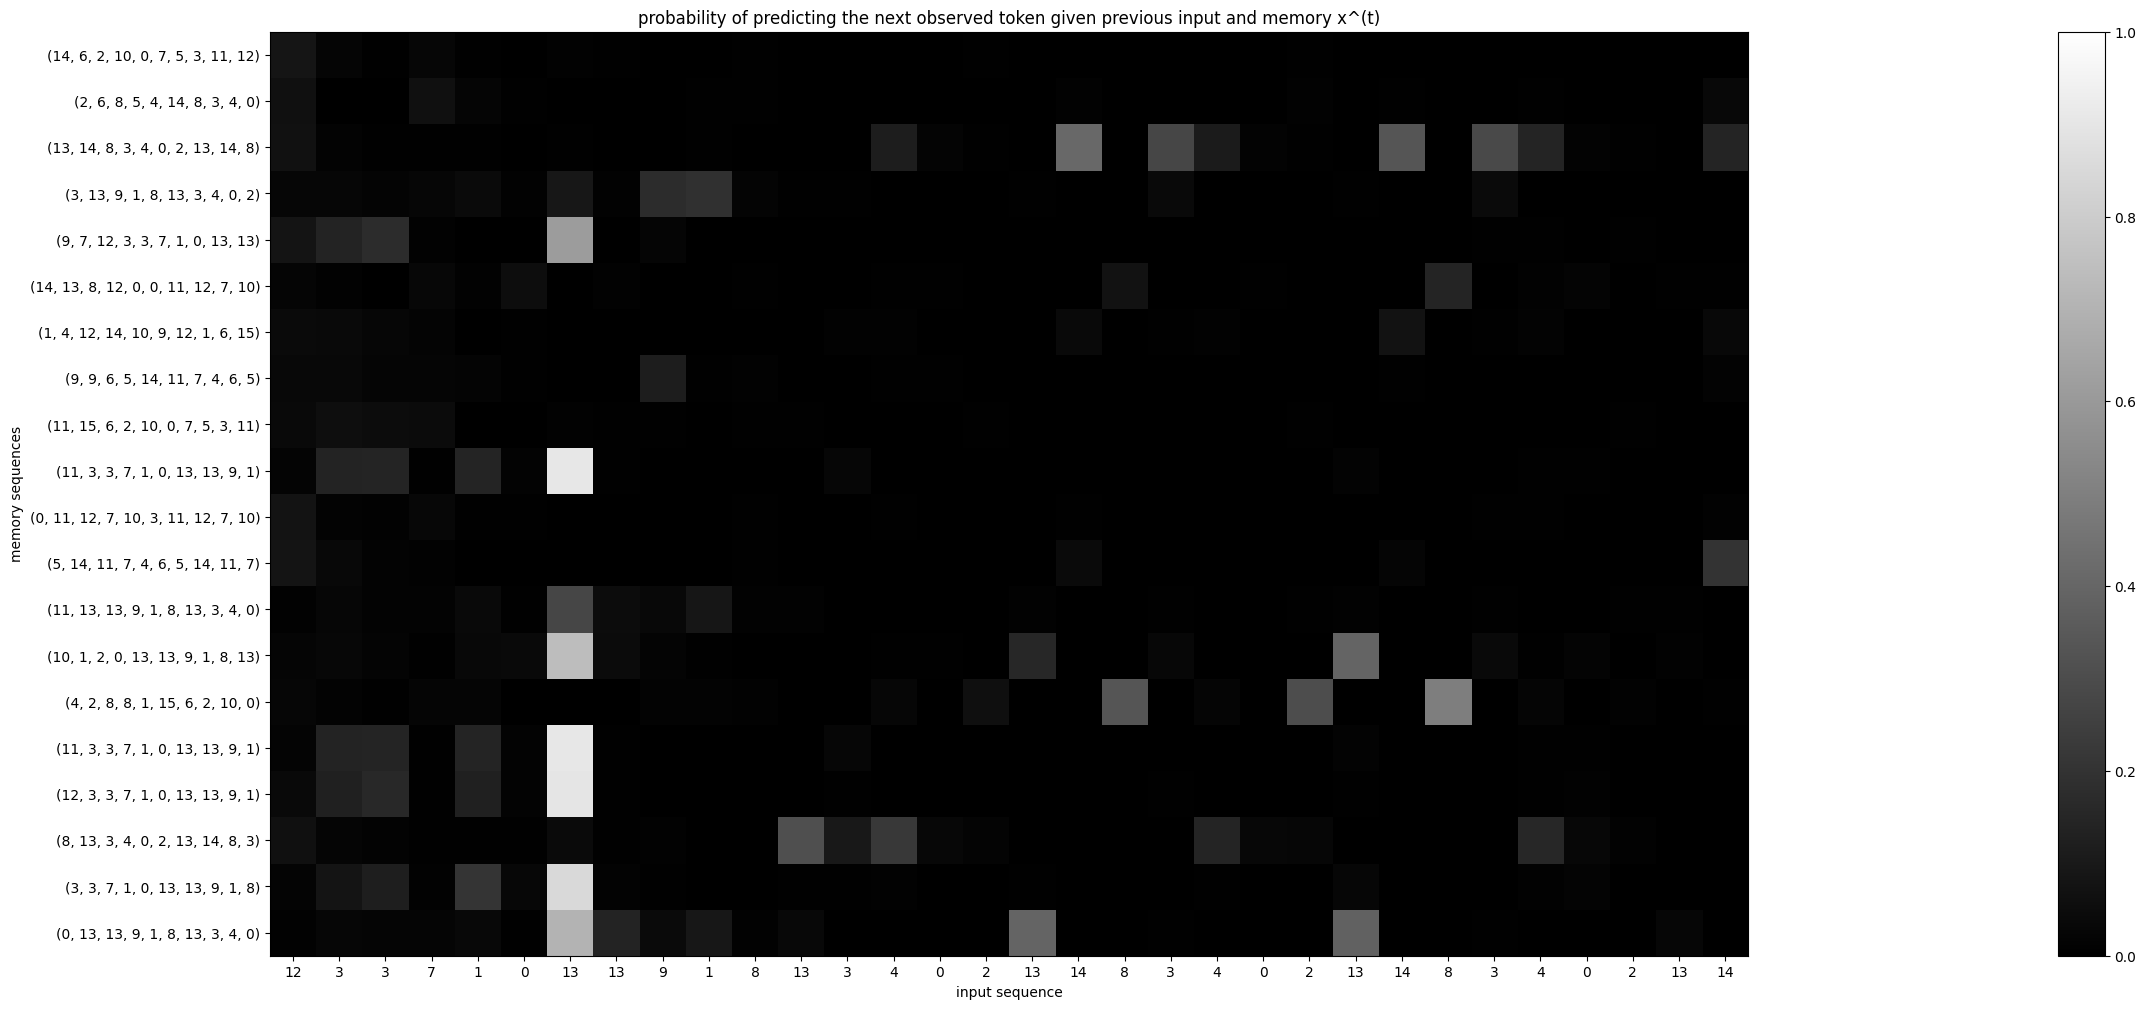

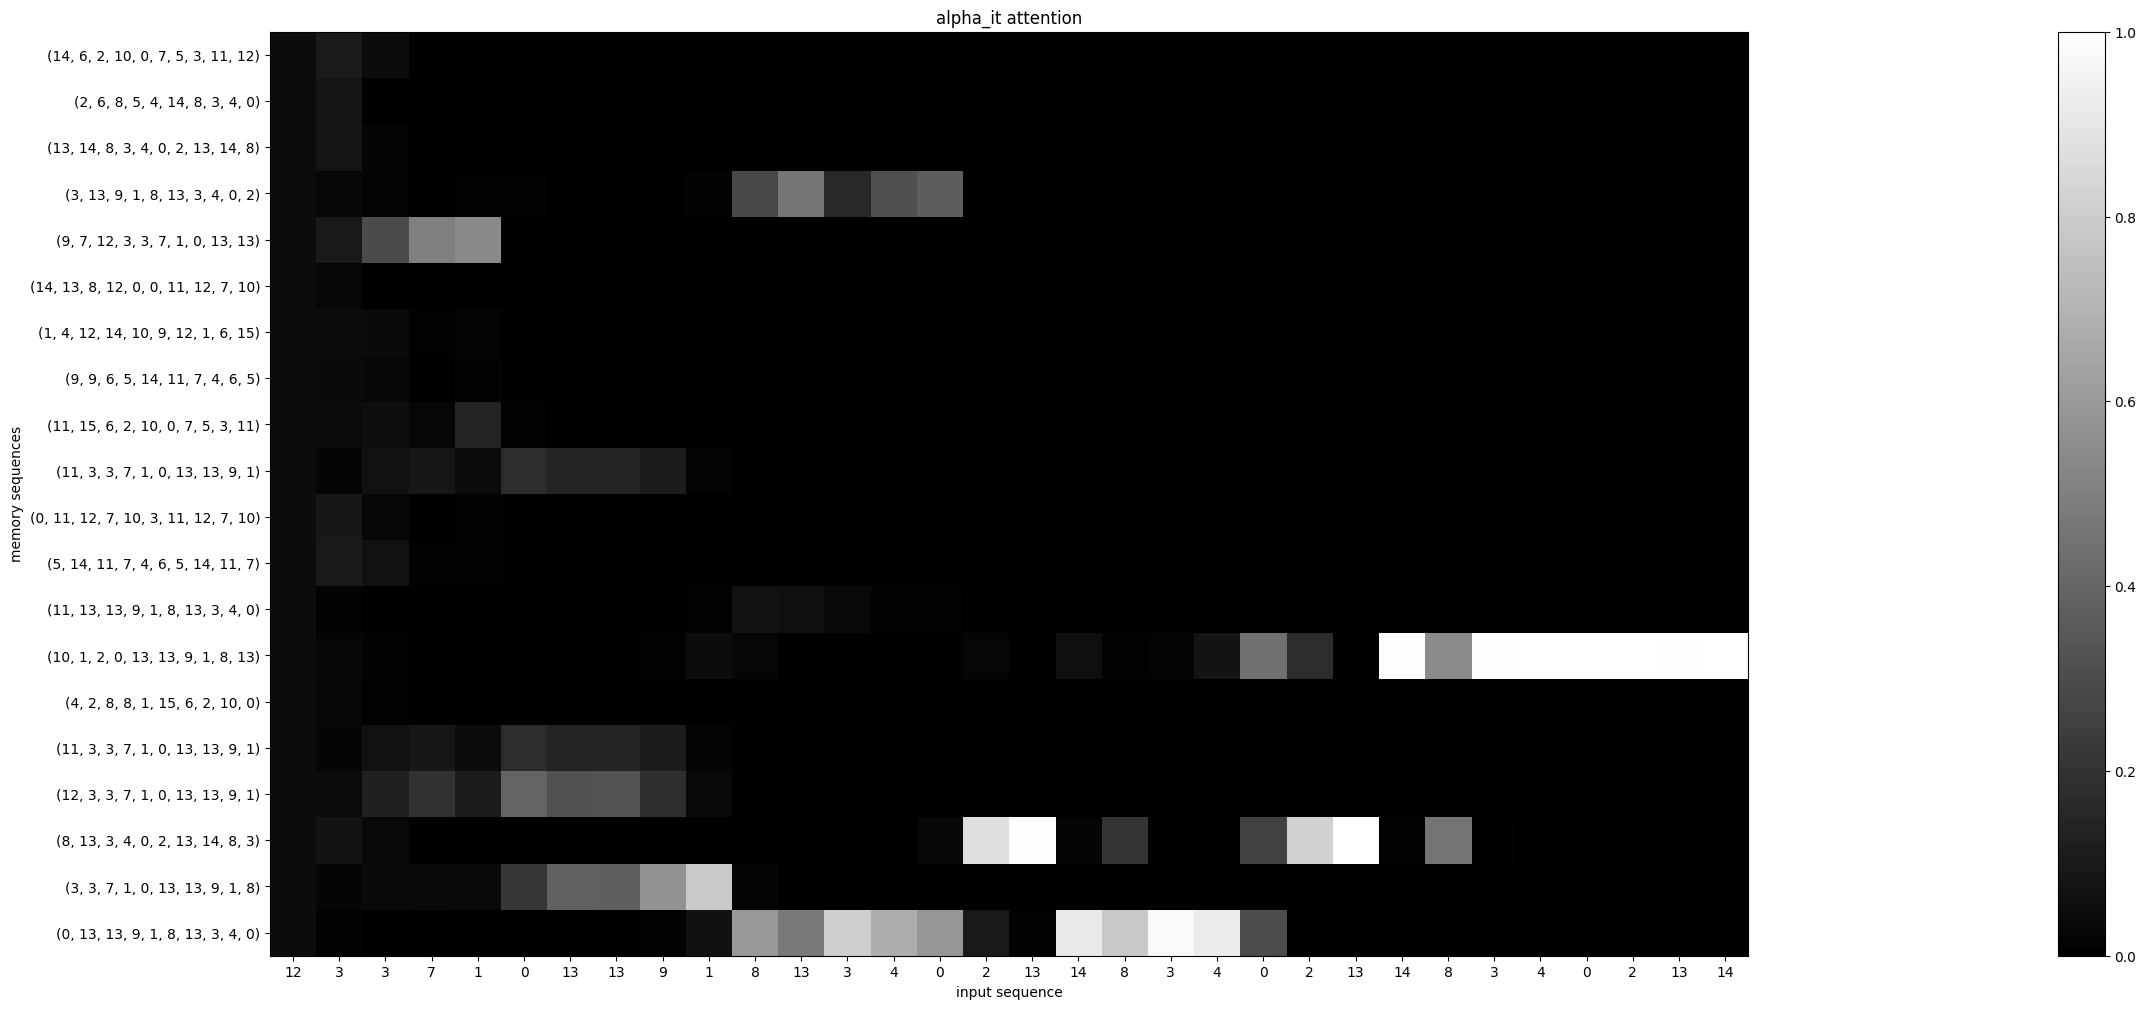

In [15]:
idx = np.random.choice(len(seqs_x_test))
print('kernel_model_cross_y')

plot_cross_prob_observed_and_attn_crossAttn_y(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, kernel_model_cross_y)

kernel_model_cross_y
sample_input:  [[14  6  7  6  4  6 15 11  7 11  3  9 12  1  2 10 13 15  8 12 15 12  0 11
   9  4 11  8  8  1 13  3]]


prediction: [ 8  2  5  9  6  9 12  9 12 12  9 12  1  2 10 13  4  8  3 15  0  0 11  9
  4 11  8  8  1  4  4  4]
y: [ 6  7  6  4  6 15 11  7 11  3  9 12  1  2 10 13 15  8 12 15 12  0 11  9
  4 11  8  8  1 13  3  3]
[False False False False  True False False False False False  True  True
  True  True  True  True False  True False  True False  True  True  True
  True  True  True  True  True False False False]


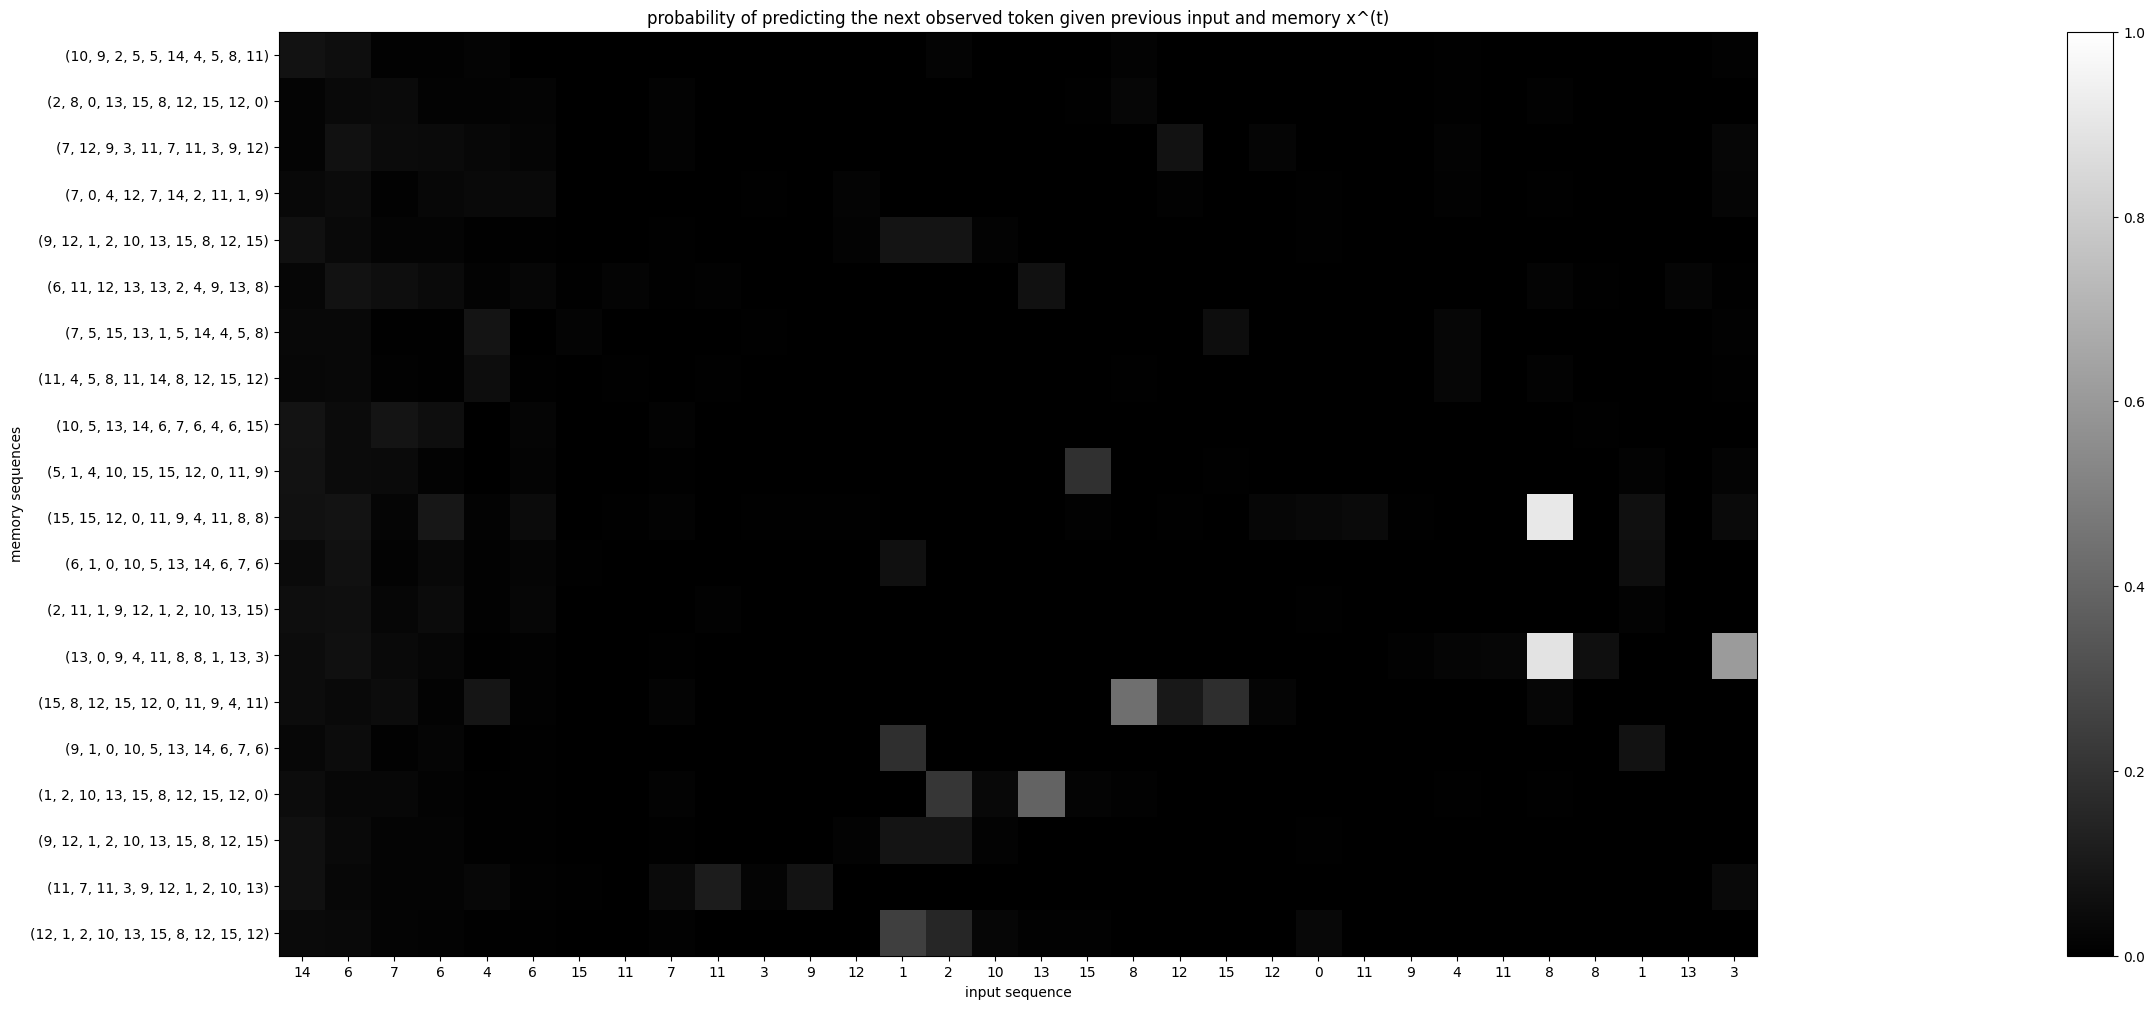

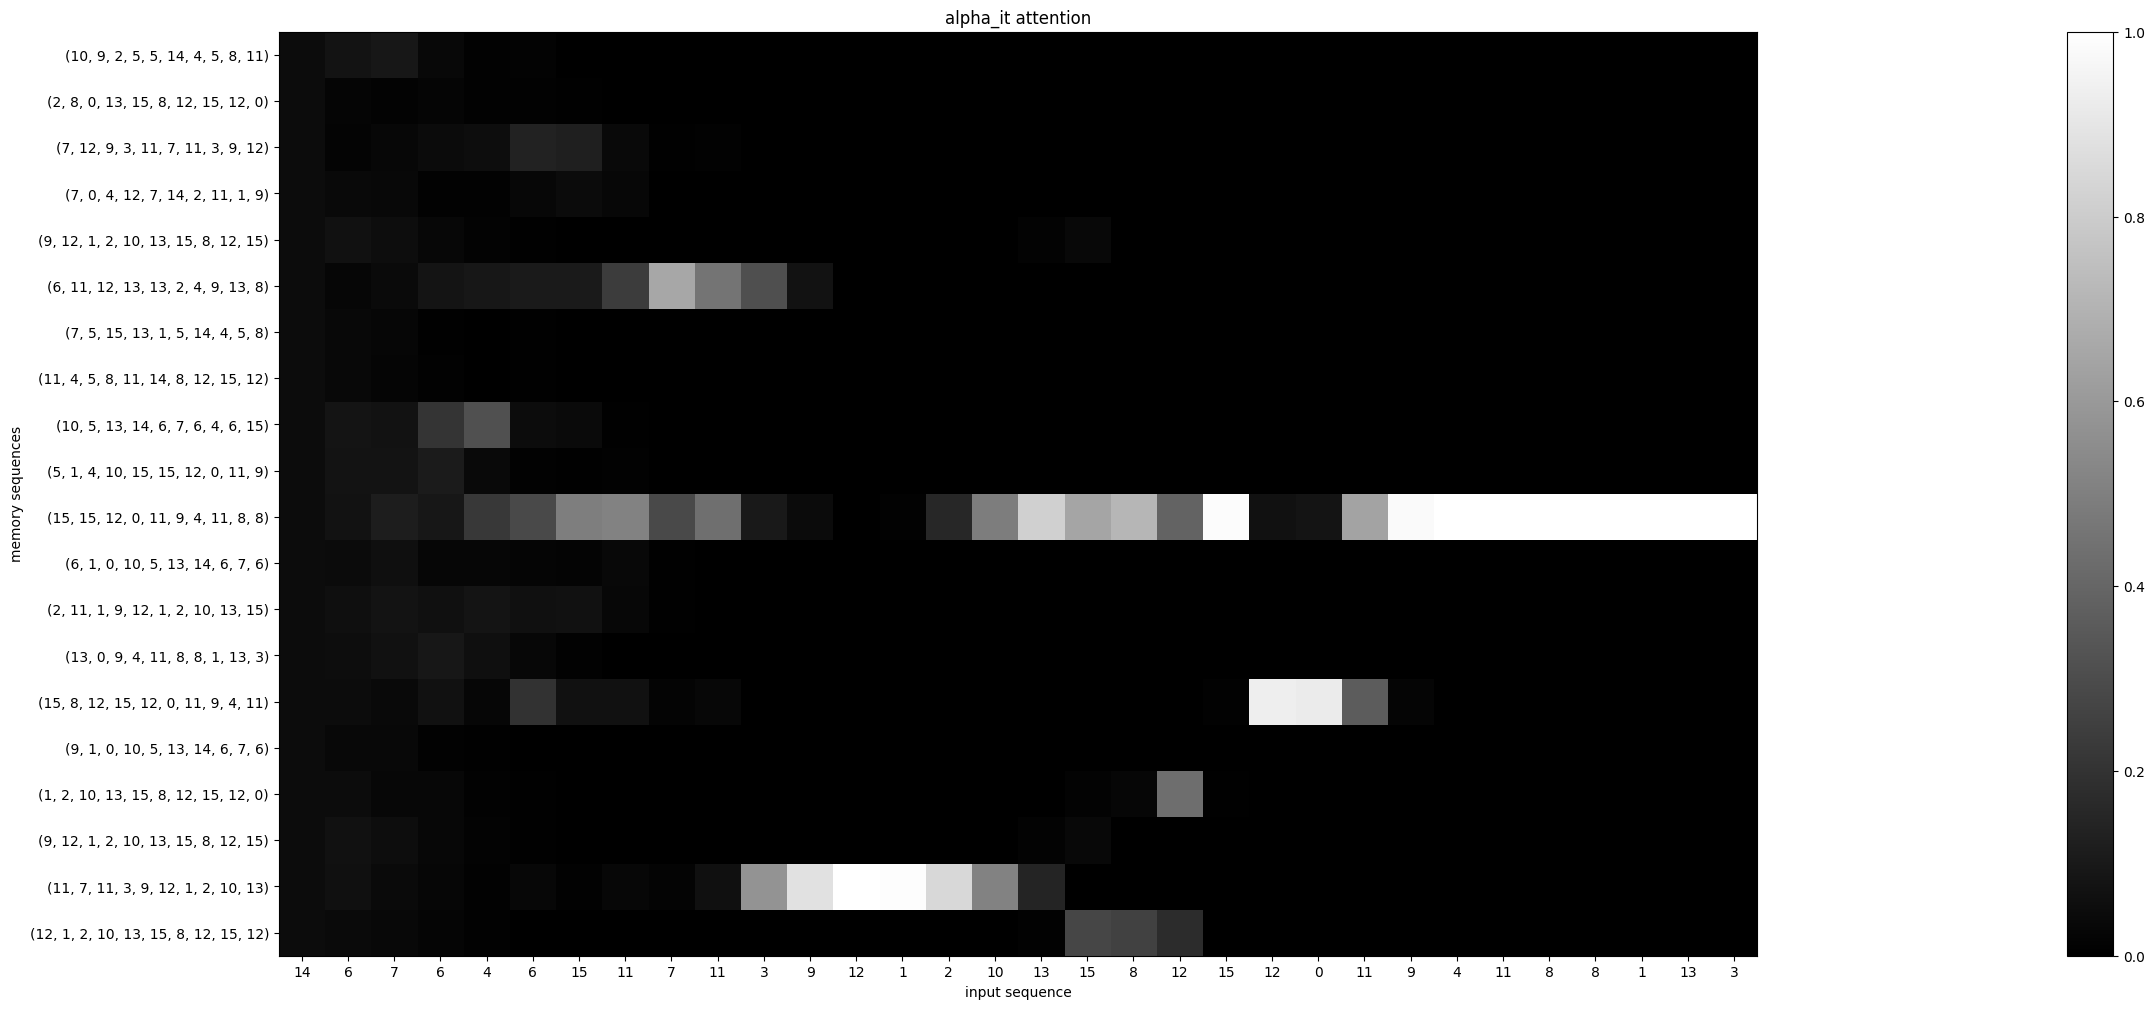

In [17]:
idx = np.random.choice(len(seqs_x_test))
print('kernel_model_cross_y')

plot_cross_prob_observed_and_attn_crossAttn_y(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, kernel_model_cross_y)


kernel_model_cross_y
sample_input:  [[12  7  8 11 14  7 11 11  0 10 11 13  5  3 13  0 14  4  1 12  9 13  1 13
  13  5  3 13  0 14  4  1]]


prediction: [14  8 11 14  7 11  0 11 10 11 13  5 14 14  5 14 14  1 12  9 13  1 13  6
  0  3  0  1 14 14  1  5]
y: [ 7  8 11 14  7 11 11  0 10 11 13  5  3 13  0 14  4  1 12  9 13  1 13 13
  5  3 13  0 14  4  1 12]
[False  True  True  True  True  True False False  True  True  True  True
 False False False  True False  True  True  True  True  True  True False
 False  True False False  True False  True False]


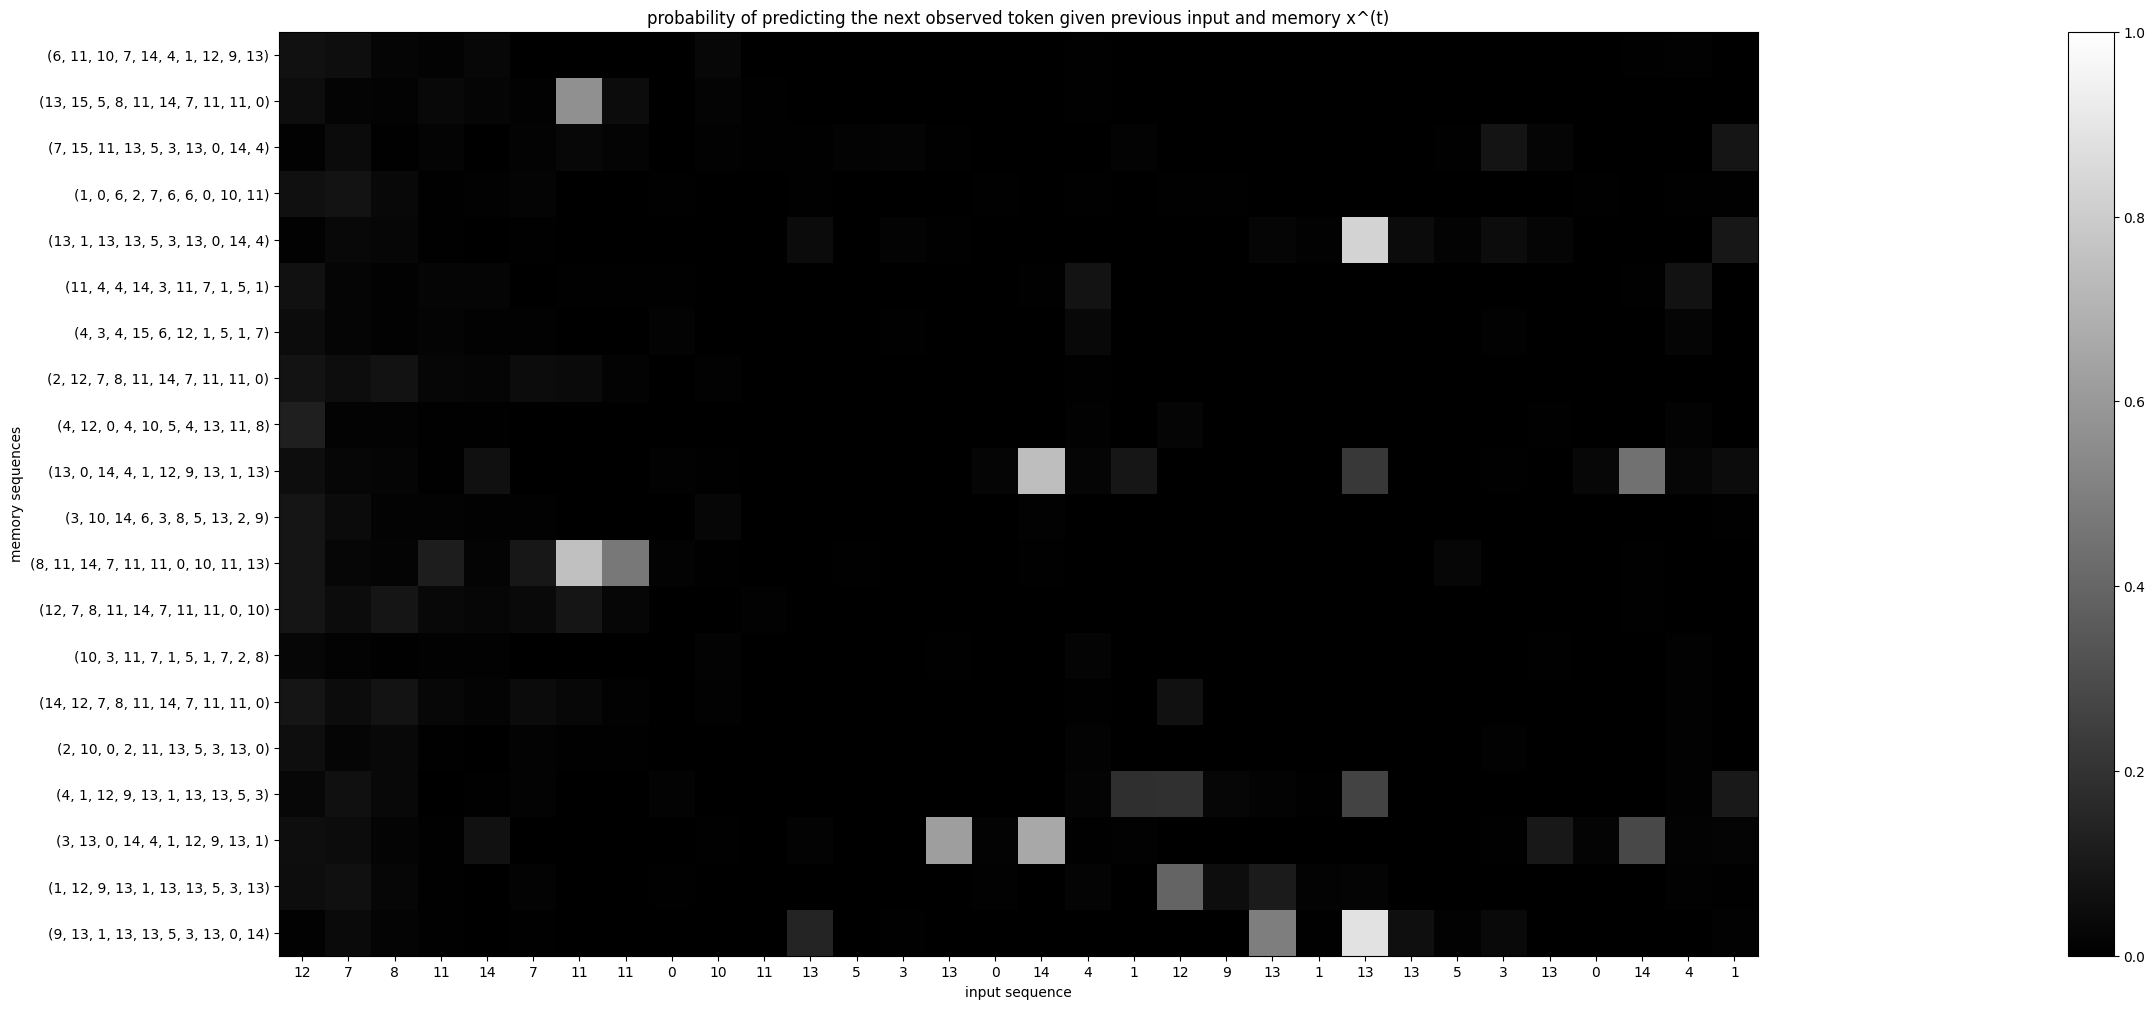

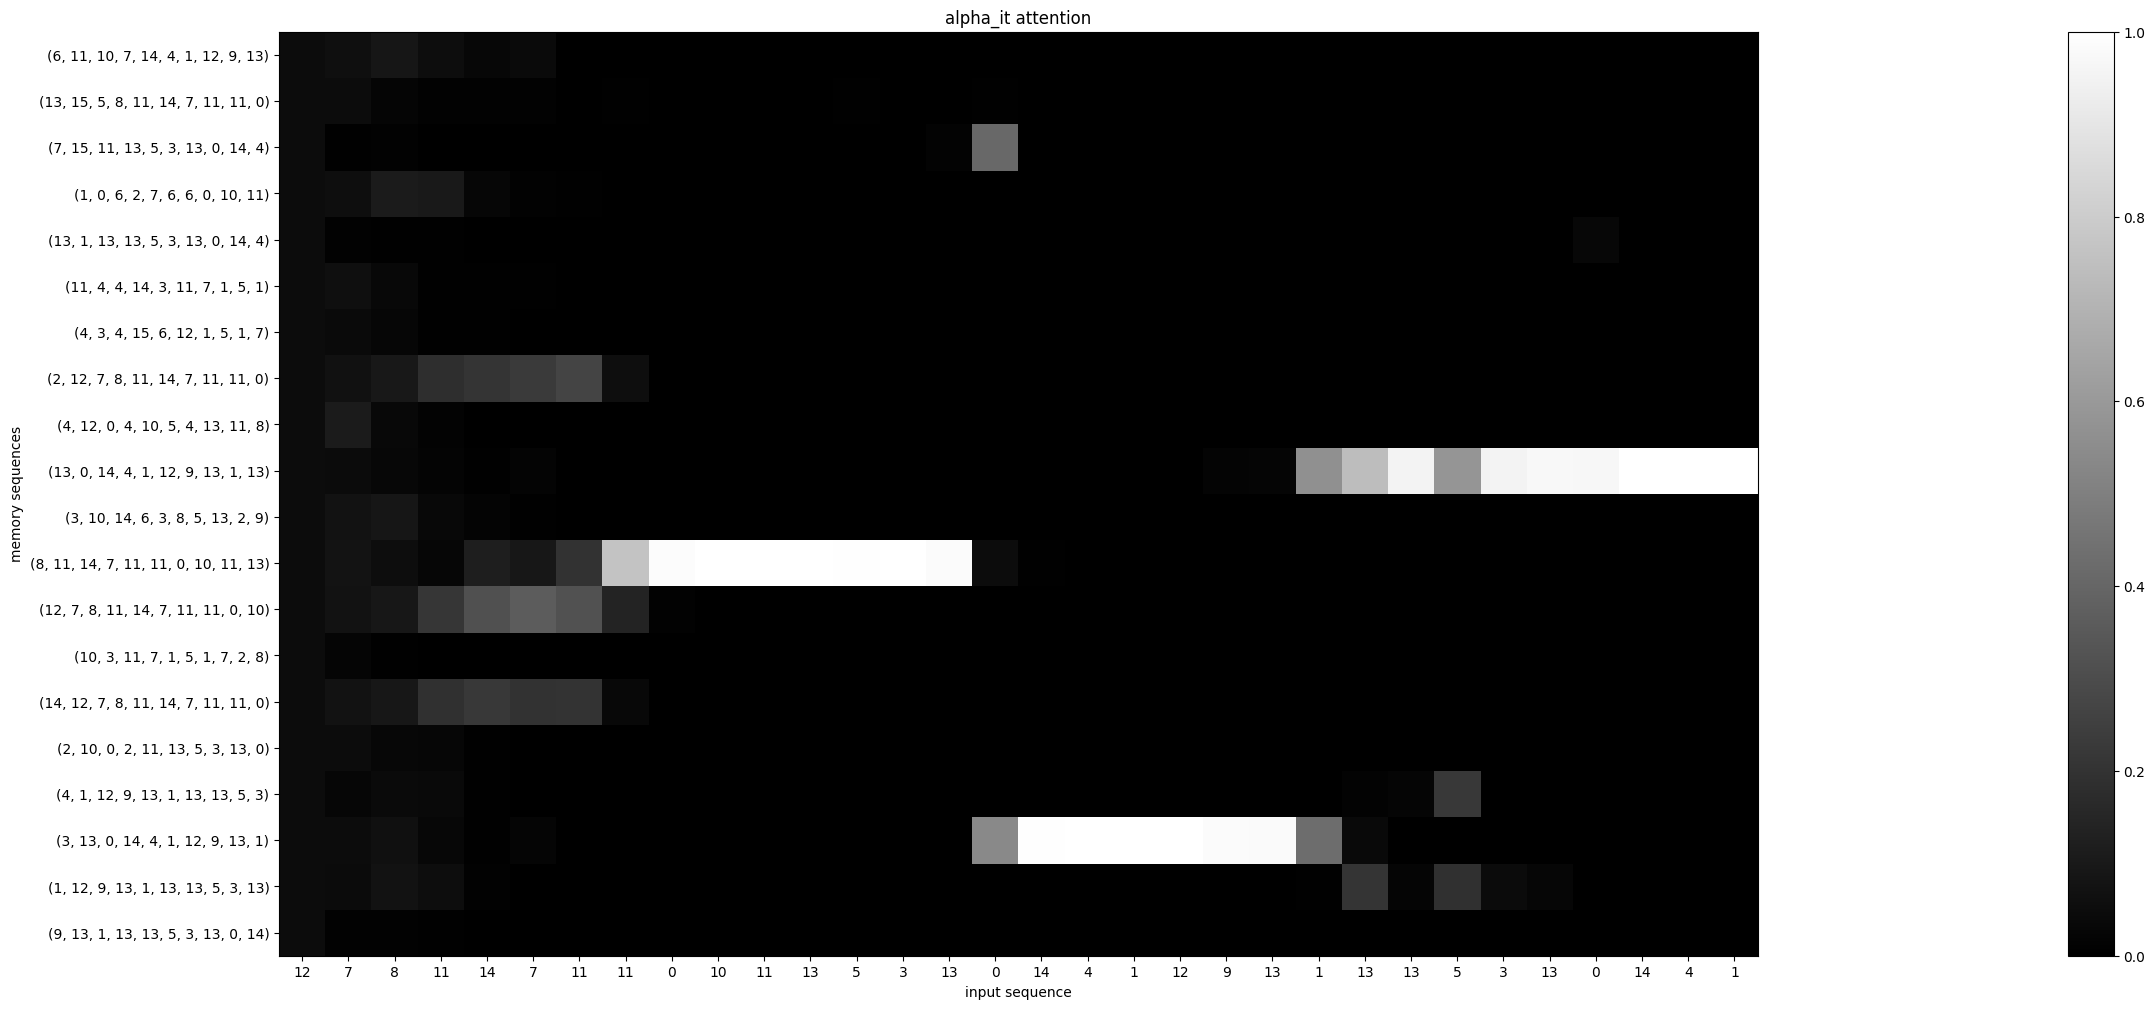

In [18]:
idx = np.random.choice(len(seqs_x_test))
print('kernel_model_cross_y')

plot_cross_prob_observed_and_attn_crossAttn_y(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, kernel_model_cross_y)


100%|██████████| 6/6 [00:15<00:00,  2.52s/it]


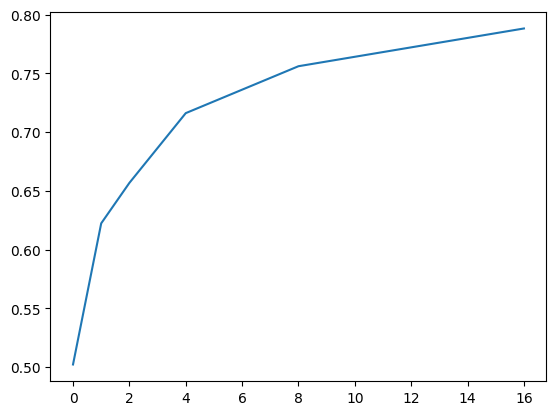

In [19]:

accs = []
nums_subseqs = [0, 1, 2, 4, 8, 16]
for num_subseqs in tqdm(nums_subseqs):
    seqs_x_test_, seqs_y_test_, mem_seqs_x_test_, mem_seqs_y_test_, sampled_test_mcs_ = sample_seqs_dataset(
        500, input_seq_len, mem_seq_len, mem_size, train_mcs, num_subseq_insertions=num_subseqs)

    test_ds_ = tf.data.Dataset.from_tensor_slices(((seqs_x_test_, mem_seqs_x_test_, mem_seqs_y_test_), seqs_y_test_)).batch(64)
    _, acc = kernel_model_cross_y.evaluate(test_ds_, verbose=0)
    accs.append(acc)

plt.plot(nums_subseqs, accs)

### Kernel Model: symmetric_attention = True, crossAttn_value_shifted = False

In [20]:
train_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_train, mem_seqs_x_train), seqs_y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test), seqs_y_test)).batch(64)

In [21]:
vocab_size = n_states
embedding_dim = 64
kernel_model_cross_y2 = KernelMemoryTransformer(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, ff_sizes = [vocab_size//2,], symmetric_attention = True, name='kernel_model_cross_y2')


kernel_model_cross_y2([seqs_x_train[:64], mem_seqs_x_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
kernel_model_cross_y2.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
kernel_model_cross_y2.summary()

Model: "kernel_model_cross_y2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  1024      
                                                                 
 pos_embedder_adder (AddPos  multiple                  0         
 itionalEmbedding)                                               
                                                                 
 mem_pos_embedder_adder (Me  multiple                  0         
 moryAddPositionalEmbedding                                      
 )                                                               
                                                                 
 causal_self_attention_1 (C  multiple                  12608     
 ausalSelfAttention)                                             
                                                                 
 cross_attention_1 (CrossAt  multiple        

100%|██████████| 30/30 [06:45<00:00, 13.51s/epoch, loss=1.53, accuracy=0.592, val_loss=1.64, val_accuracy=0.564] 


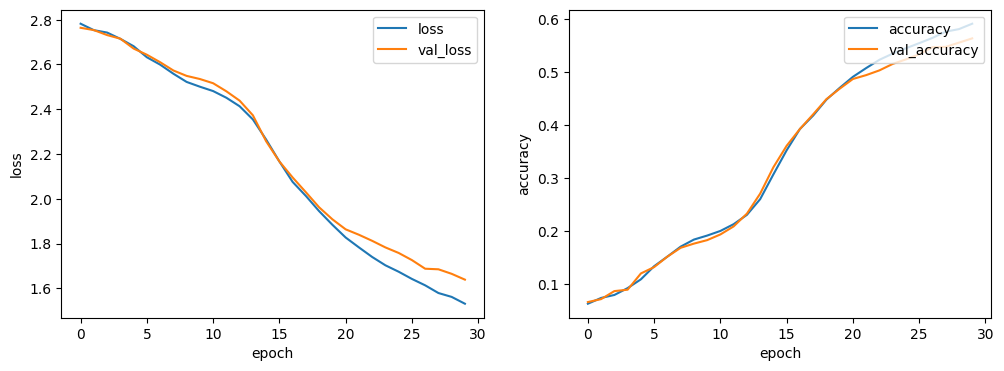

In [22]:

history3 = kernel_model_cross_y2.fit(train_ds, validation_data=test_ds, verbose=0, callbacks=create_callbacks(), **fit_kwargs)
utils.plot_history(history3, plot_attrs=('loss', 'accuracy'), val=True, figsize=(12,4));

40/40 [==============================] - 3s 42ms/step


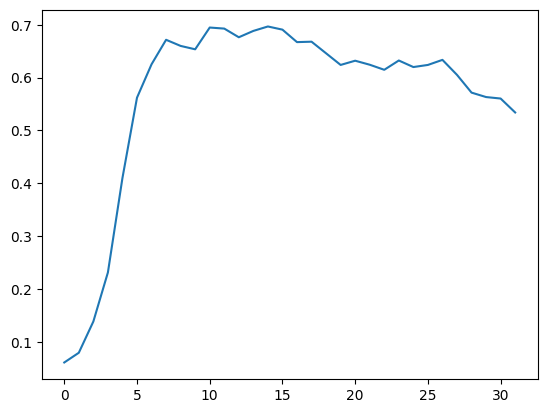

In [23]:
# plot accuracy as a function of position in sequence
preds = kernel_model_cross_y2.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

kernel_model_cross_y2
sample_input:  [[ 5  3 13  9  2 11  9 14  1  8  0  5  1  6  2 13  6 10 13 12  7  0  6  0
   3  8  5  7  2 12  0  9]]


prediction: [ 2 10 14 10 11 13 14  1  8  0  5  1  6  7 13  6 10 13 13  2  0  6  0  3
 13 10  2 13 12  0  9 15]
y: [ 3 13  9  2 11  9 14  1  8  0  5  1  6  2 13  6 10 13 12  7  0  6  0  3
  8  5  7  2 12  0  9 15]
[False False False False  True False  True  True  True  True  True  True
  True False  True  True  True  True False False  True  True  True  True
 False False False False  True  True  True  True]


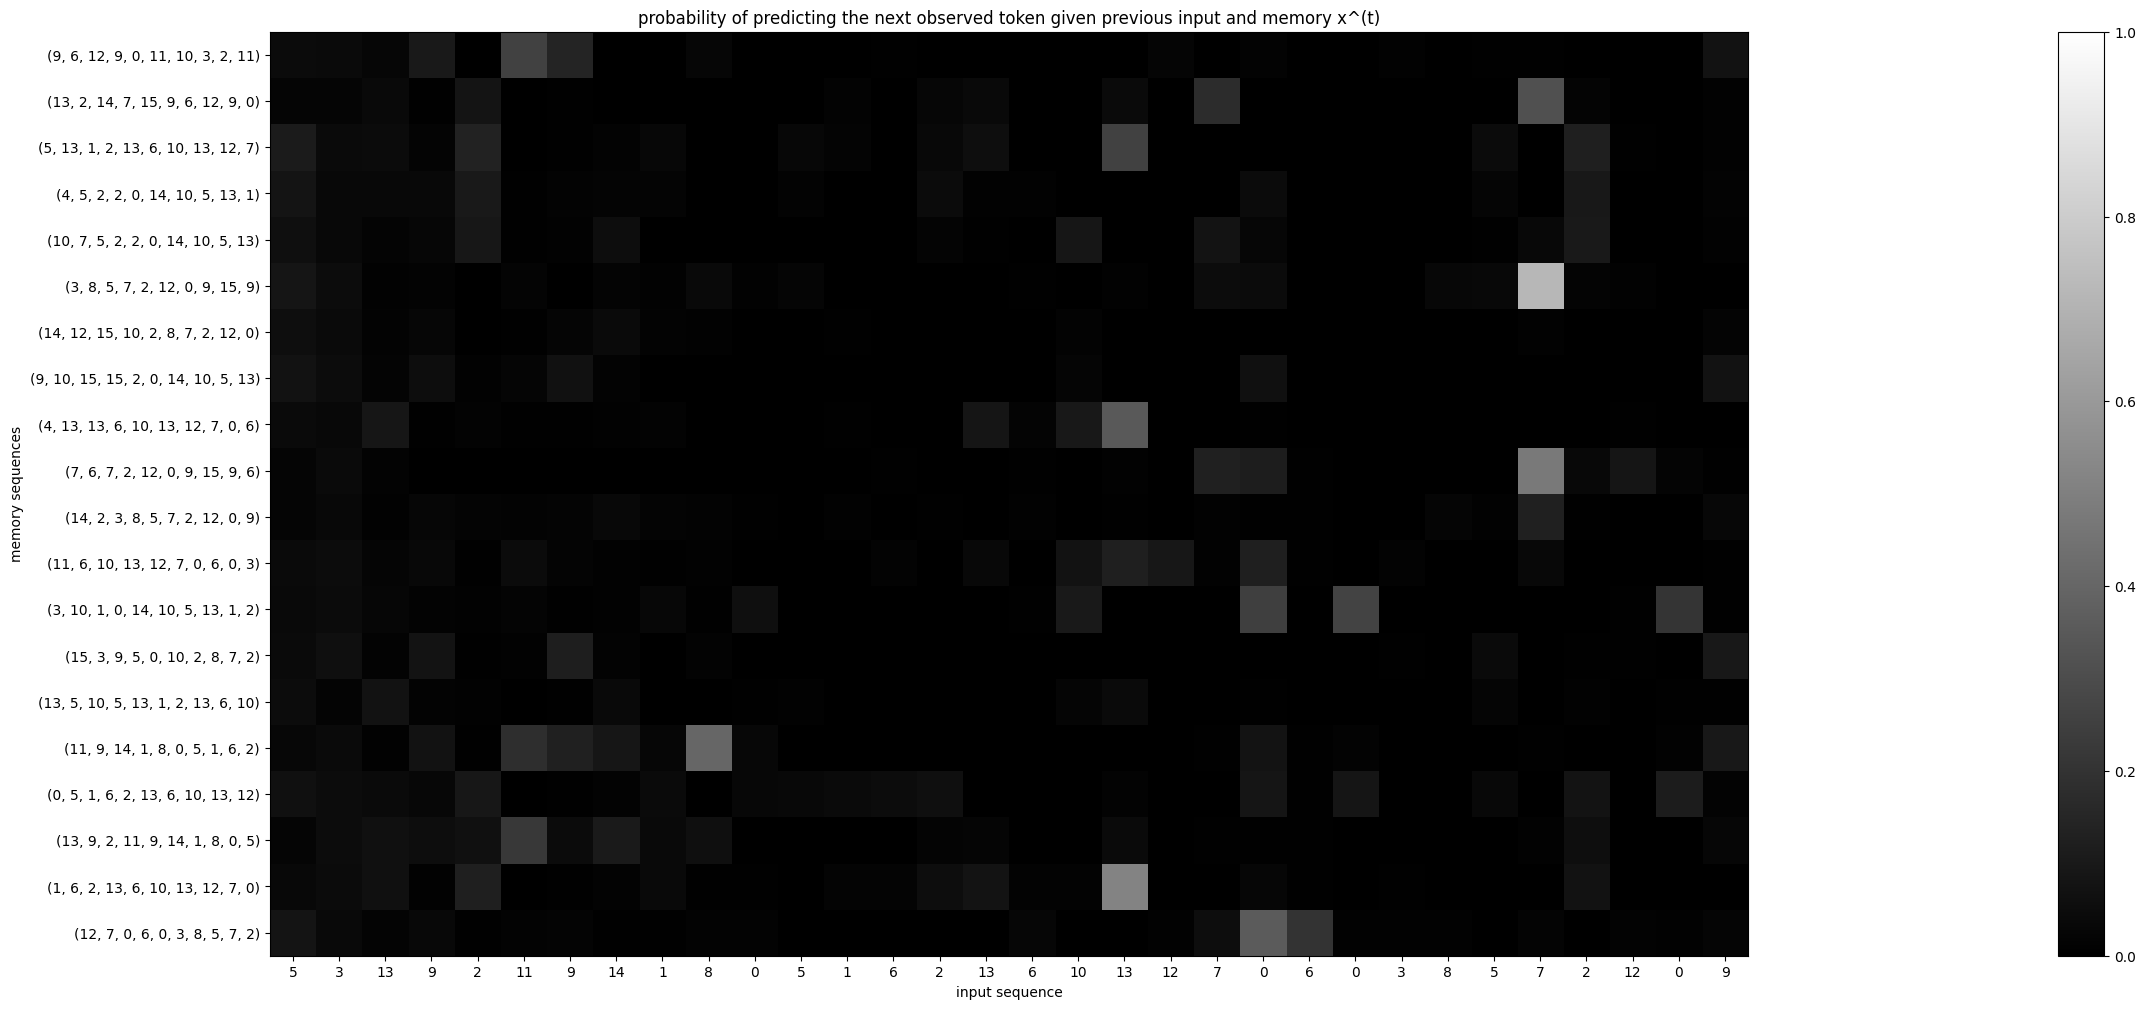

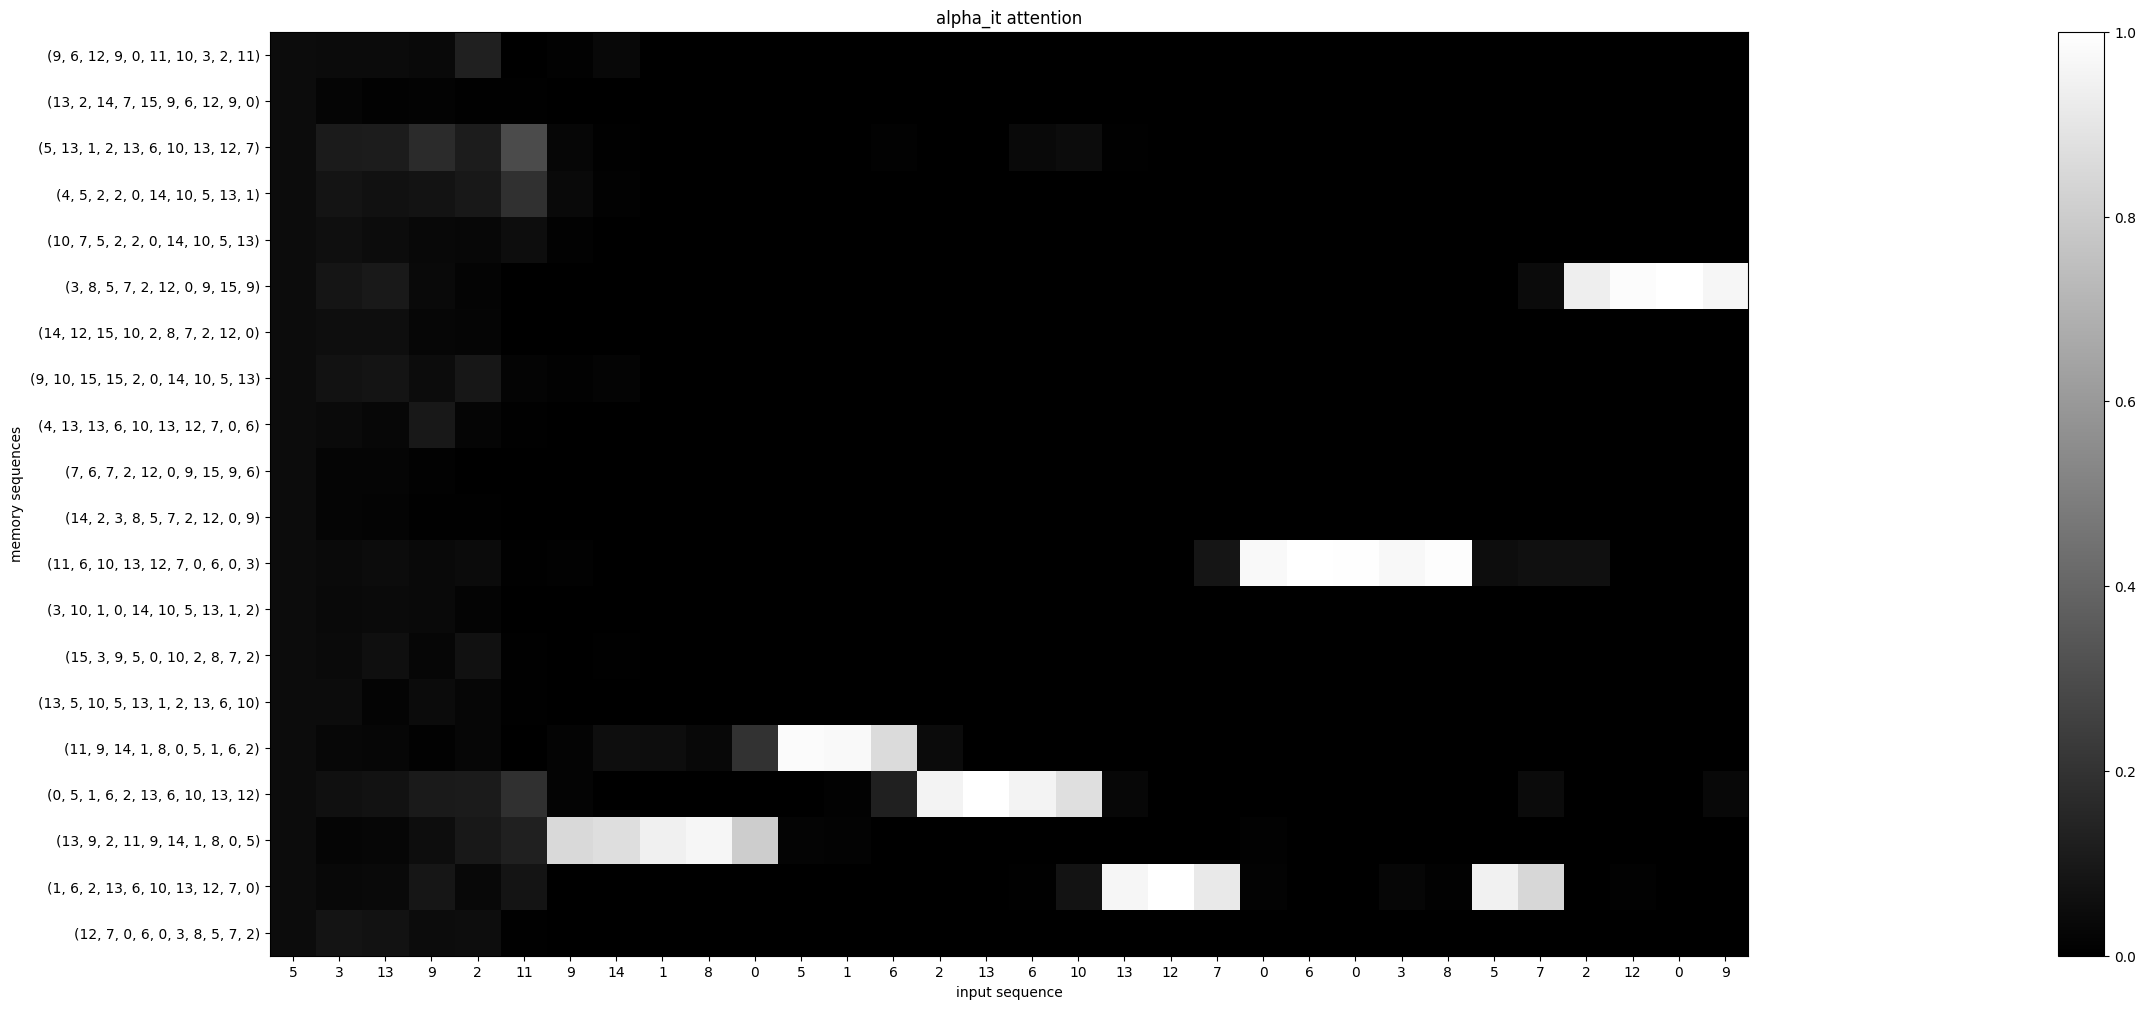

In [24]:
idx = np.random.choice(len(seqs_x_test))
print('kernel_model_cross_y2')

plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, kernel_model_cross_y2)


kernel_model_cross_y2
sample_input:  [[15 12  0 12  0 12  0 12  0 12  0 12  0 12  0 12  0 12  0 12  0 12  0 12
   0 12  0 12  0 12  0 12]]
prediction: [ 5  8 12 10 12  0 12  0 12  0 12  0 12  0 12  0 12  0 12  0 12  0 12  0
 12  0 12  0 12  0 12  0]
y: [12  0 12  0 12  0 12  0 12  0 12  0 12  0 12  0 12  0 12  0 12  0 12  0
 12  0 12  0 12  0 12  0]
[False False  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


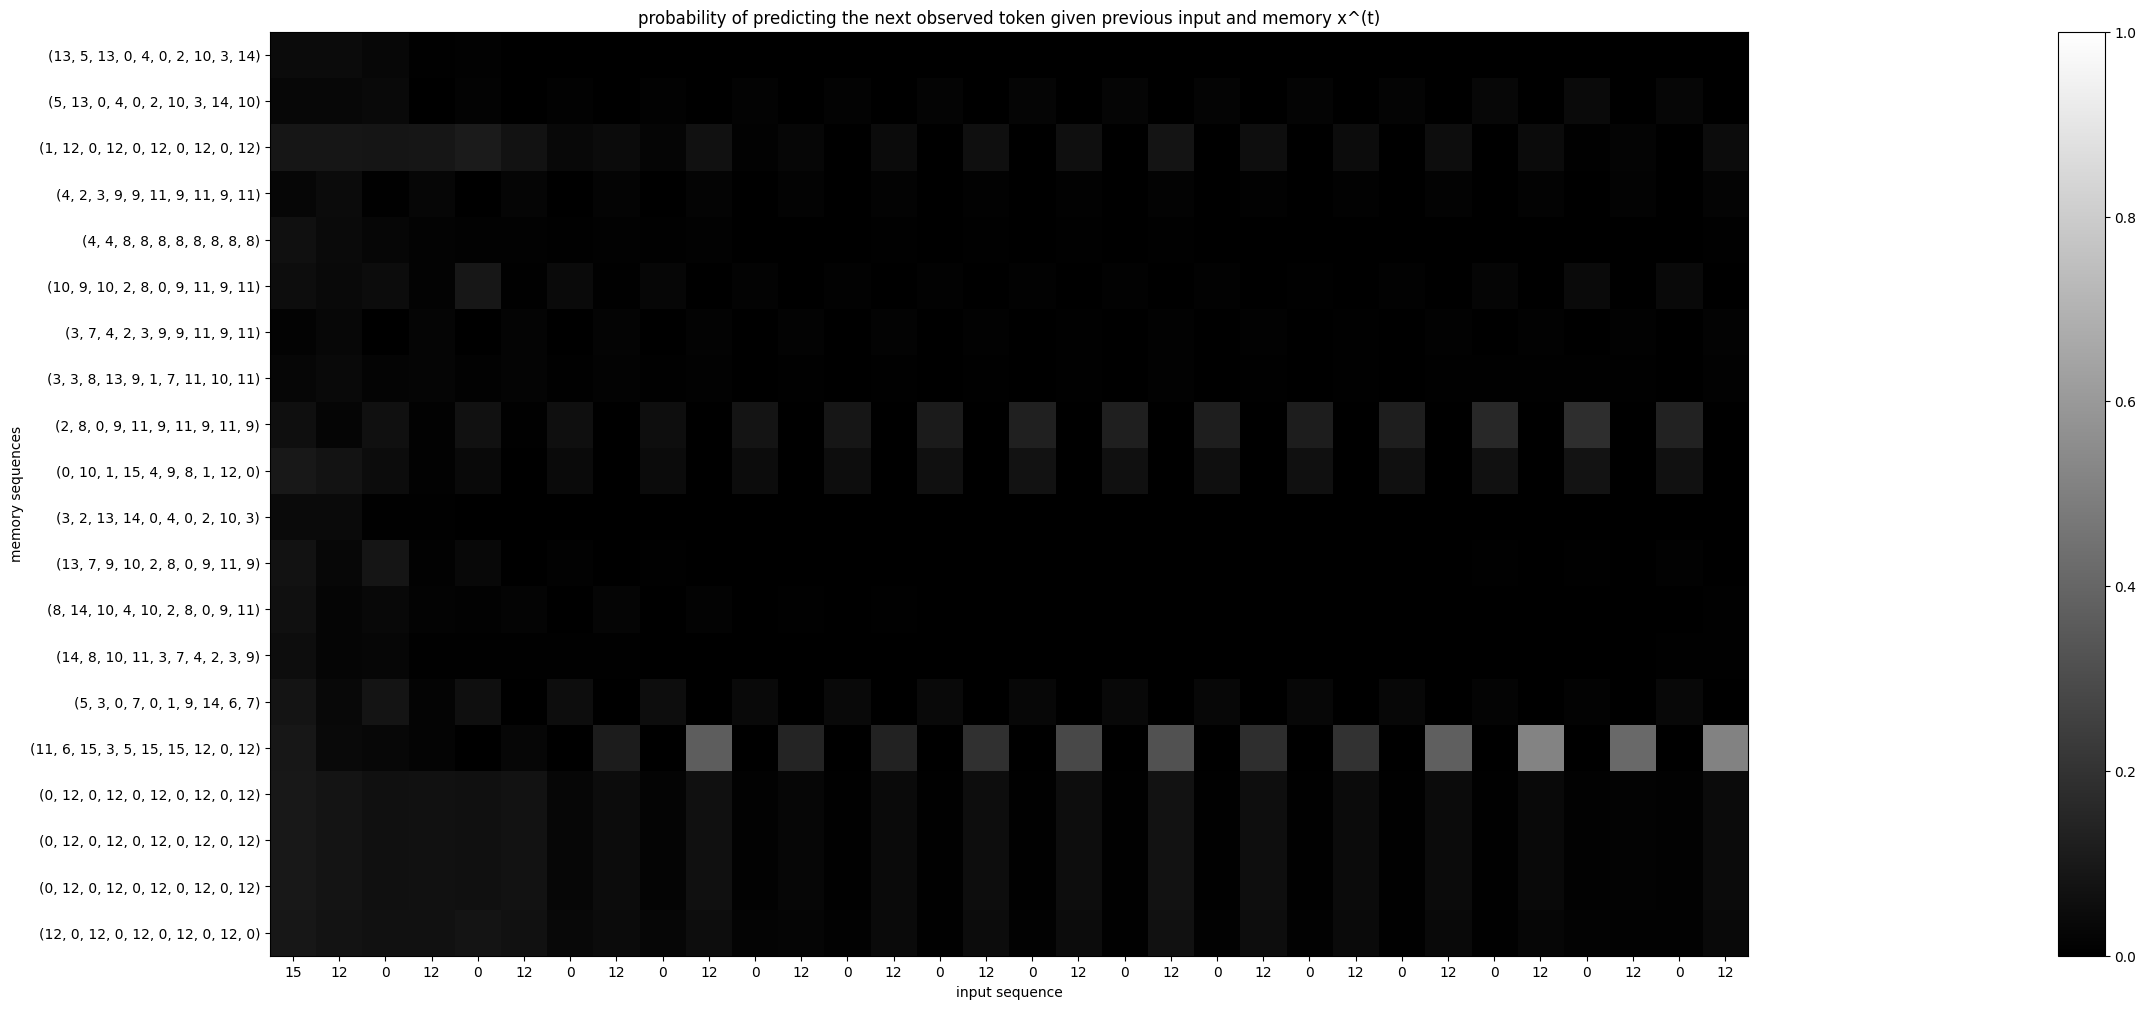

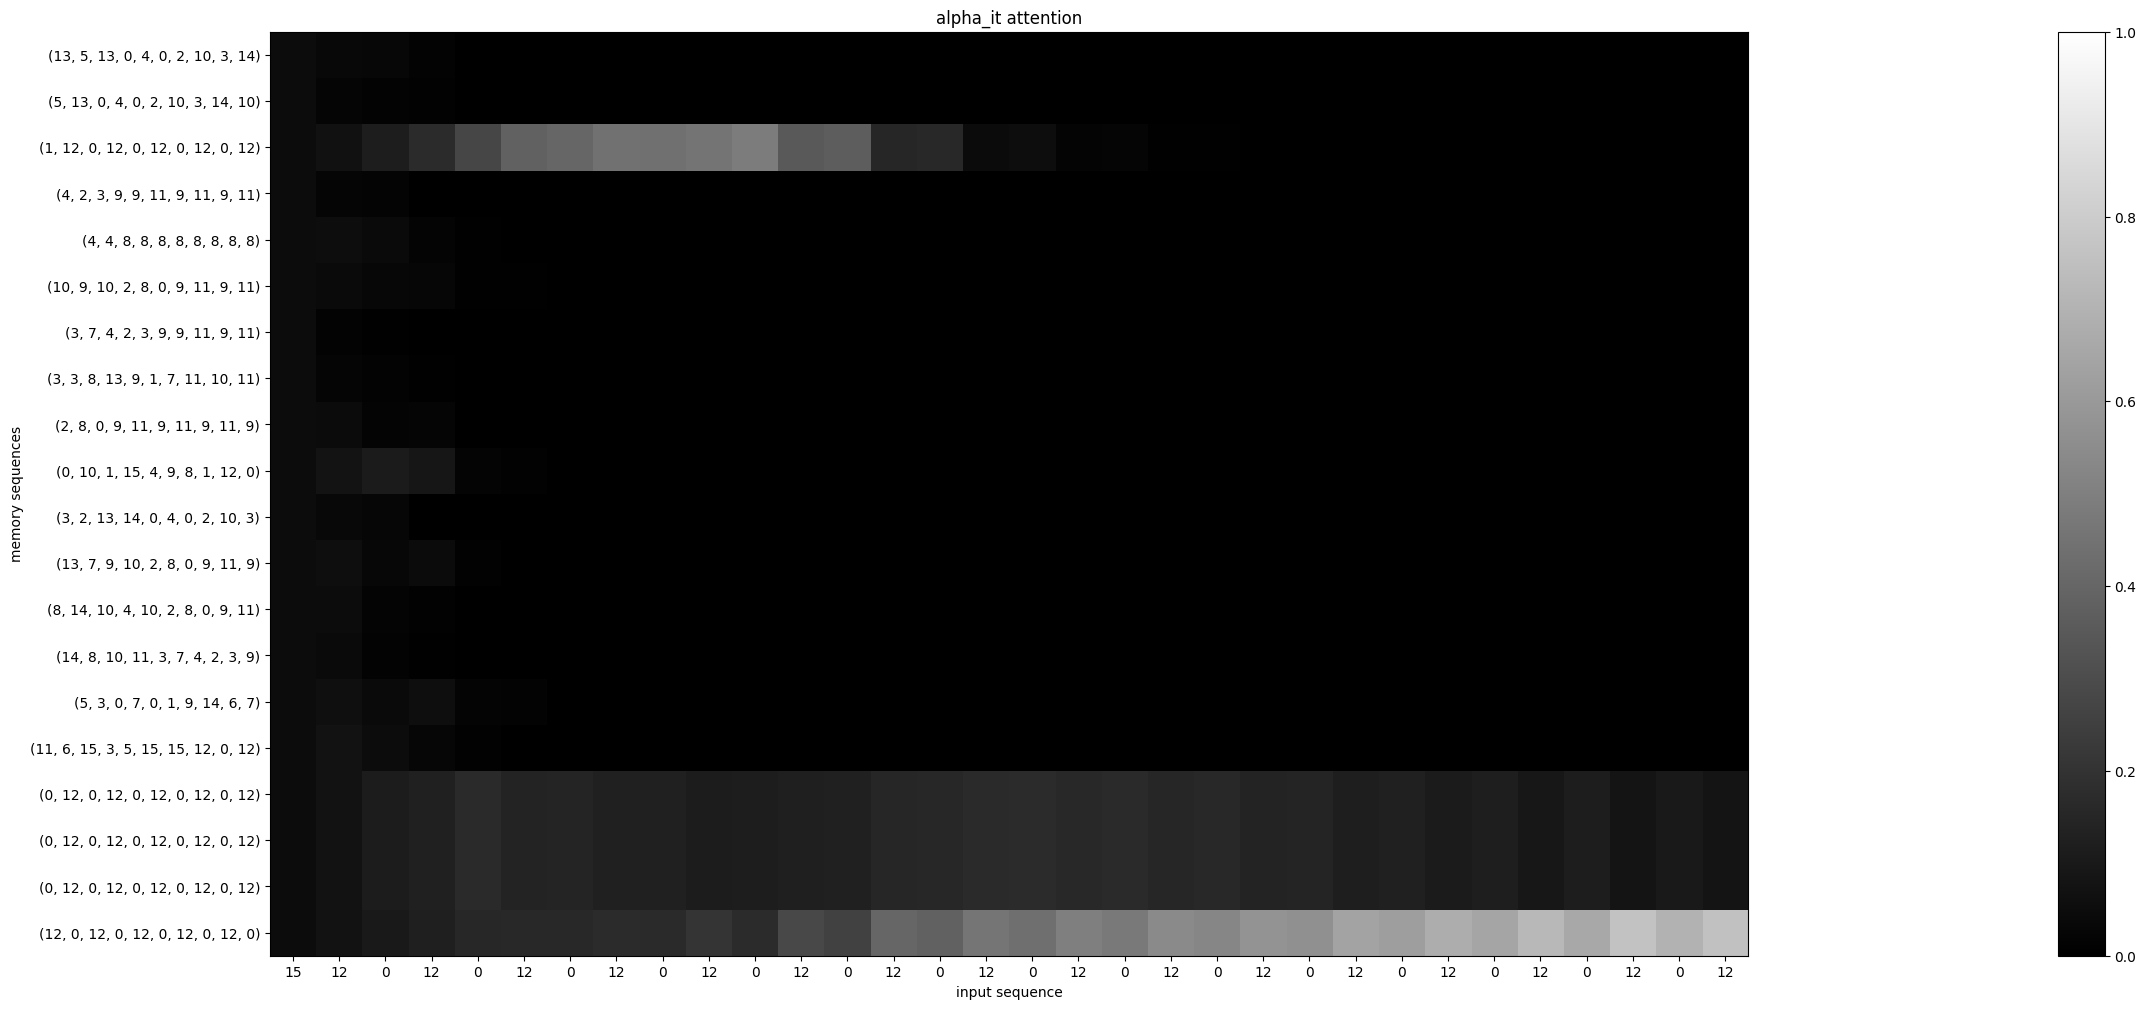

In [25]:
idx = np.random.choice(len(seqs_x_test))
print('kernel_model_cross_y2')

plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, kernel_model_cross_y2)


kernel_model_cross_y2
sample_input:  [[11  1 14  1  0  6 14 13  0  7  3  6  8 12  8 12  8 12  8 12  8 12  8 12
   8 12  8 12  8 12  8 12]]
prediction: [12 10  3 10  1 10  4  8 11  5 14 10 11 11 12  8 12  8 12  8 12  8 12  8
 12  8 12  8 12  8 12  8]
y: [ 1 14  1  0  6 14 13  0  7  3  6  8 12  8 12  8 12  8 12  8 12  8 12  8
 12  8 12  8 12  8 12  8]
[False False False False False False False False False False False False
 False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


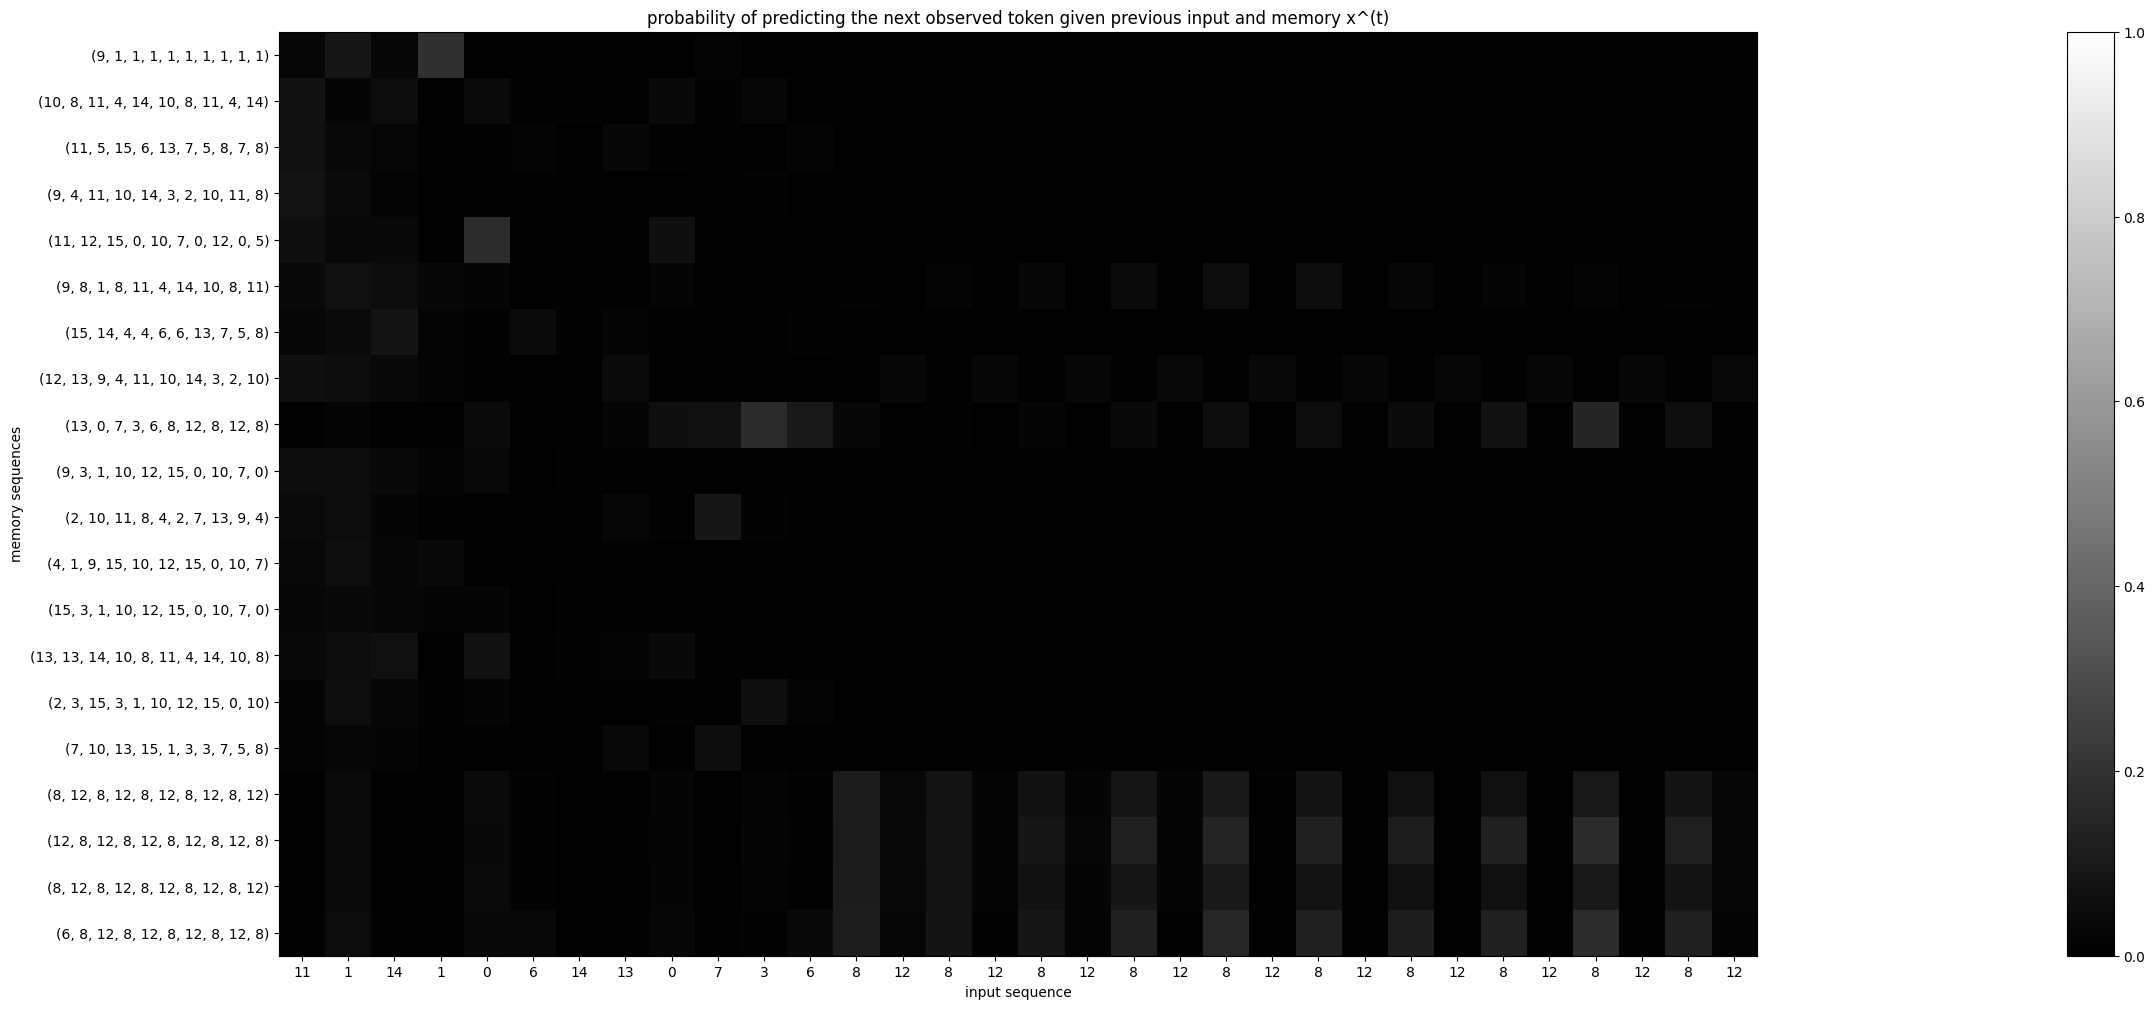

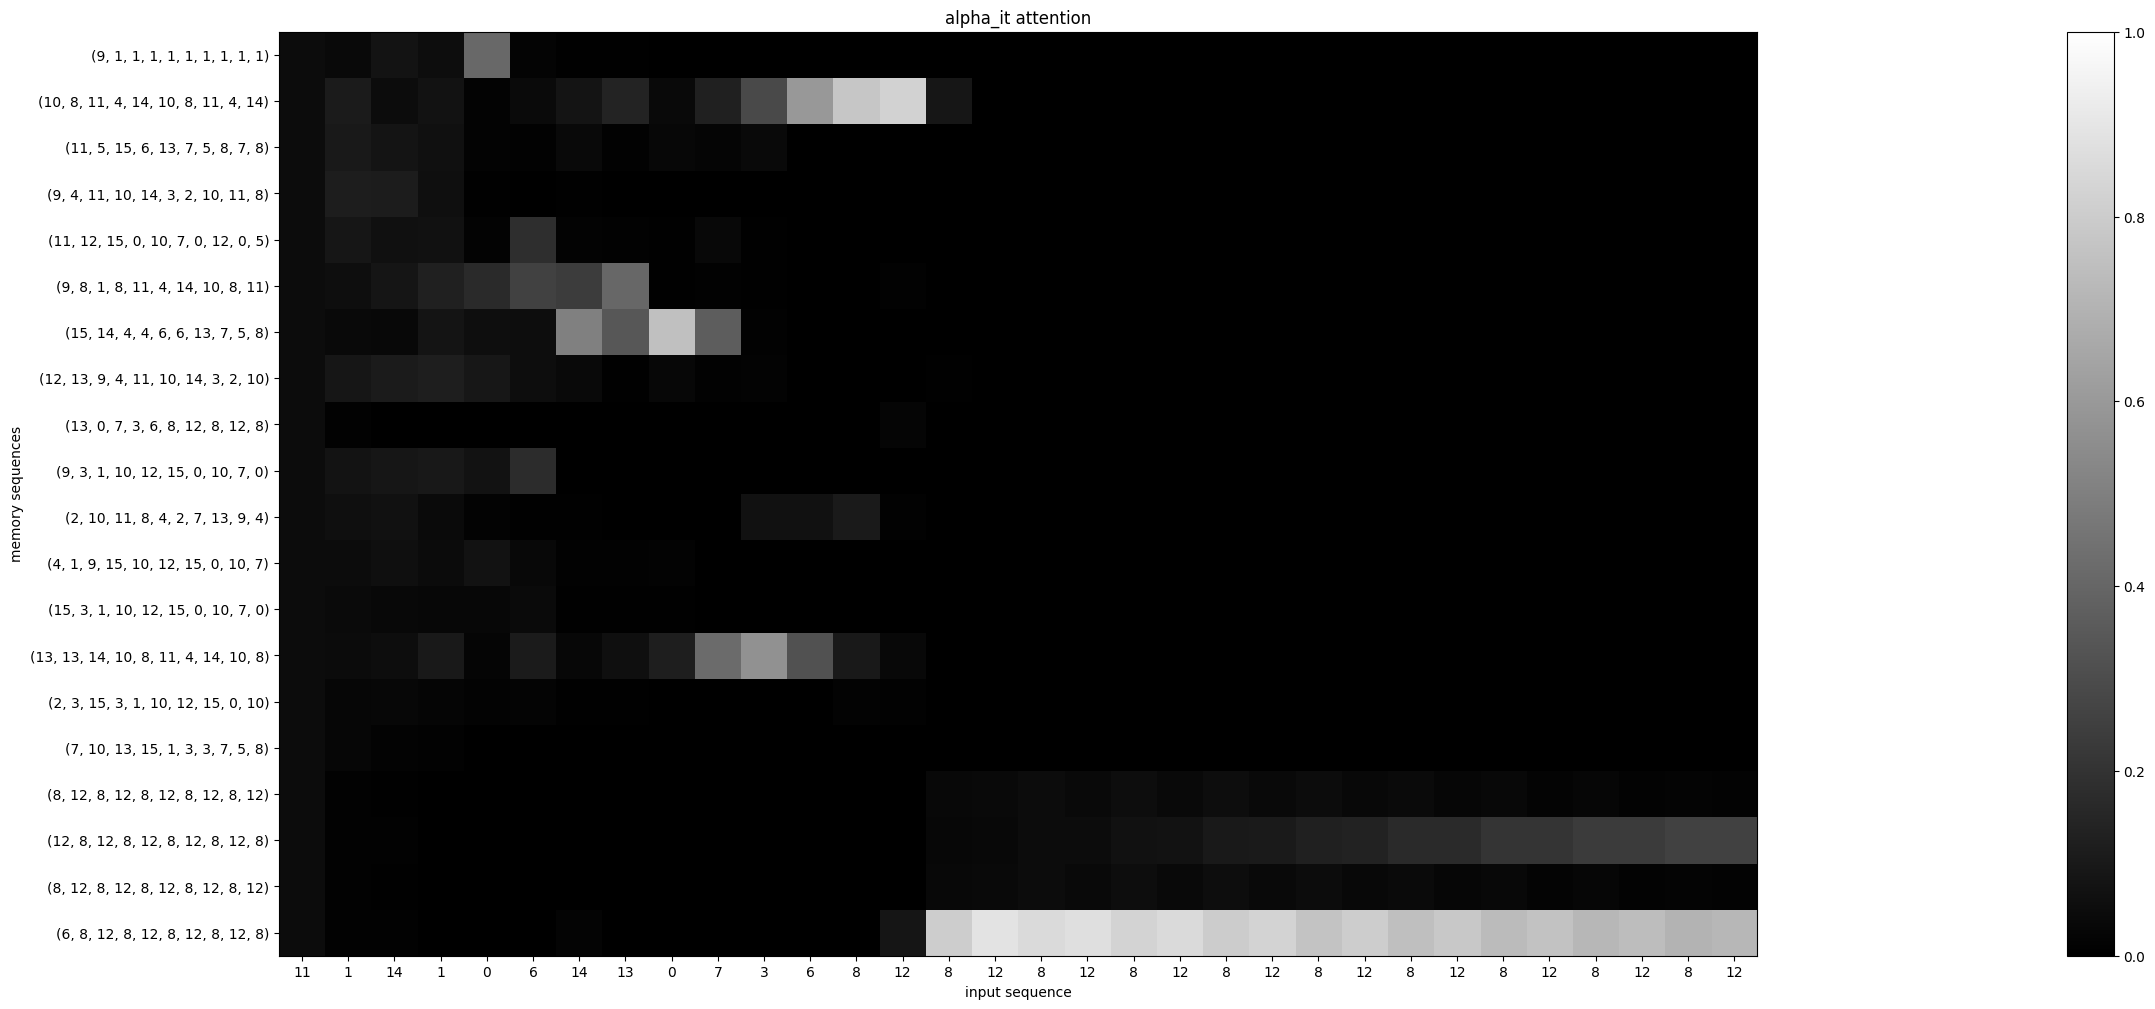

In [26]:
idx = np.random.choice(len(seqs_x_test))
print('kernel_model_cross_y2')

plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, kernel_model_cross_y2)


kernel_model_cross_y2
sample_input:  [[ 9 11 15 15  3 10  3  8  5  3  1  8  8 11  2 12  2  4  7  5 12  2  4  7
   5 12  2  4  7  5 12  2]]
prediction: [10 15  2  2 10  8  8  5  3  1 10  8 11  2  4  4  4 11  6  3 10  4  8  5
  3  2  4  4  5 12  2  4]
y: [11 15 15  3 10  3  8  5  3  1  8  8 11  2 12  2  4  7  5 12  2  4  7  5
 12  2  4  7  5 12  2  4]
[False  True False False  True False  True  True  True  True False  True
  True  True False False  True False False False False  True False  True
 False  True  True False  True  True  True  True]


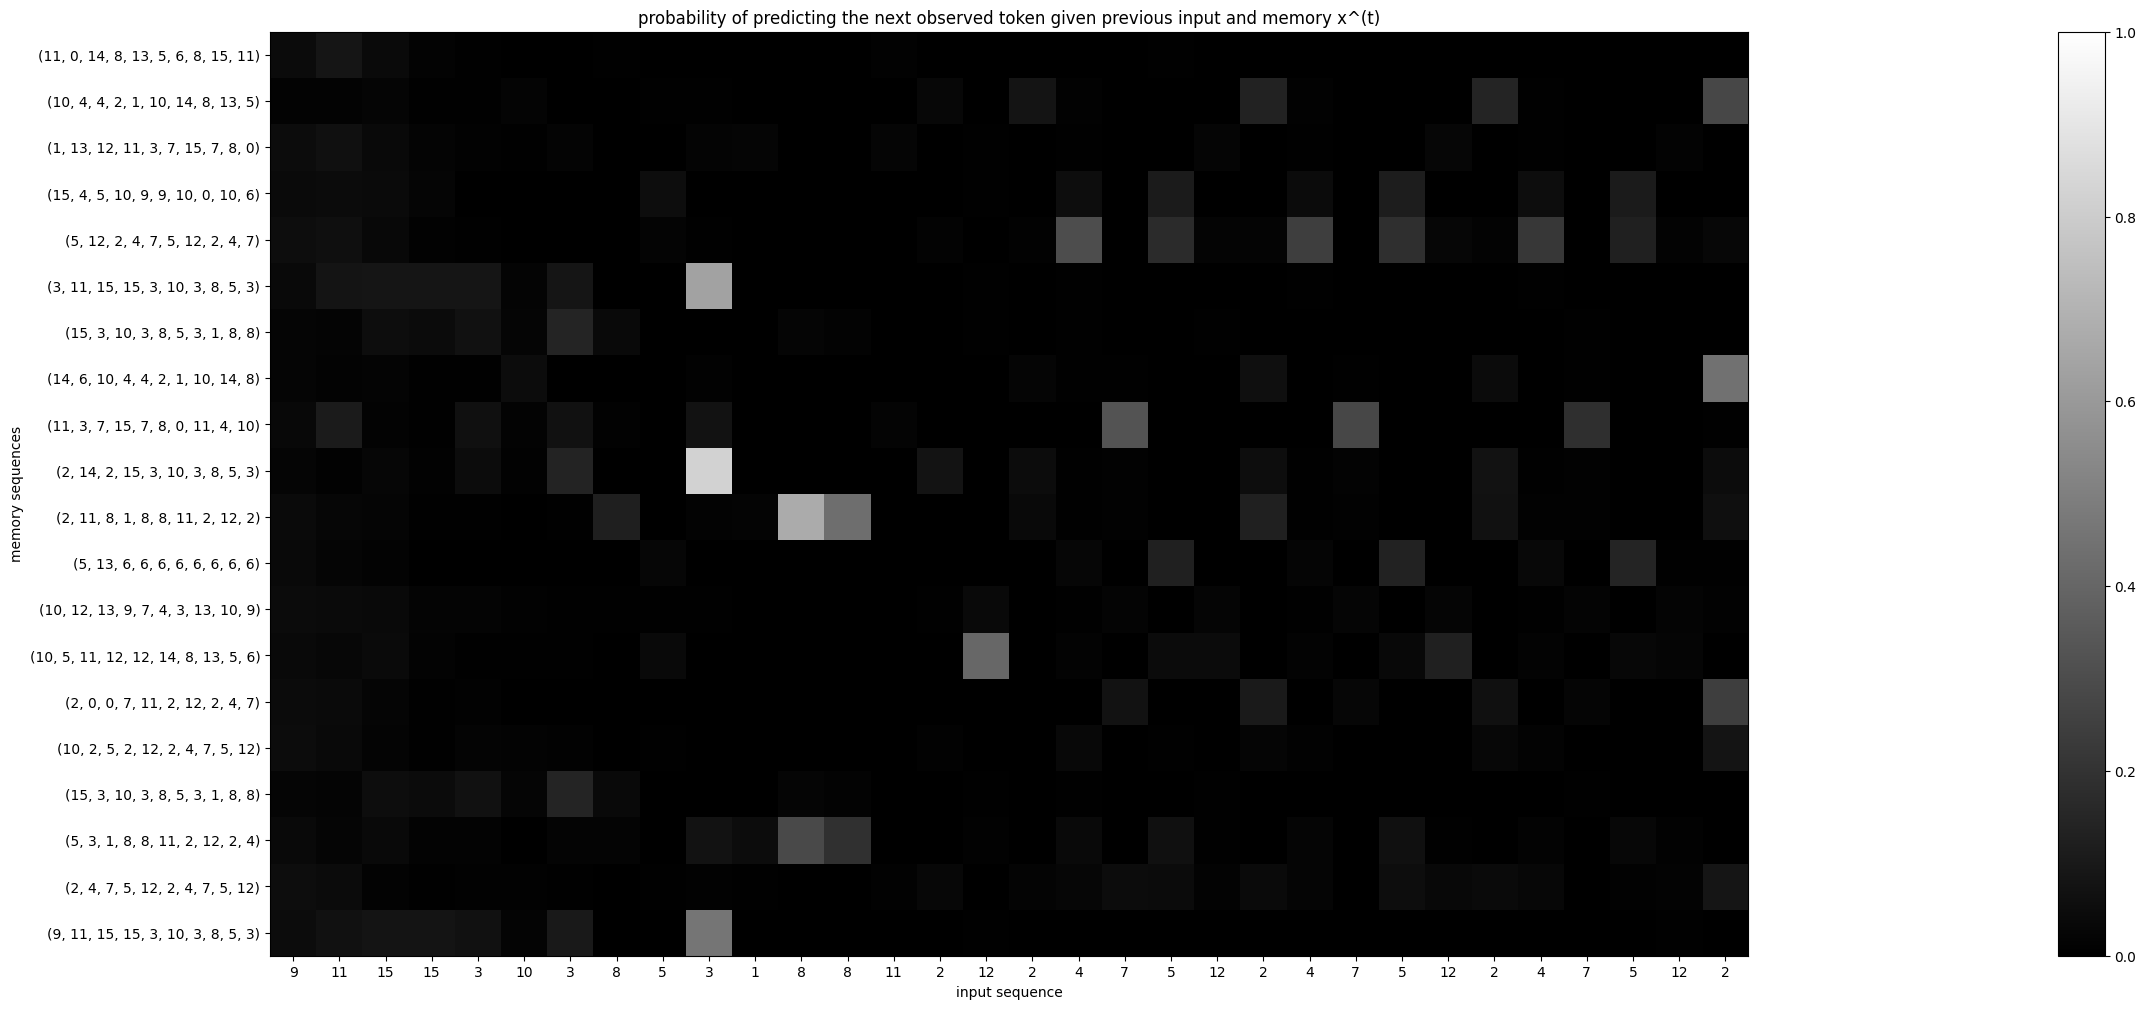

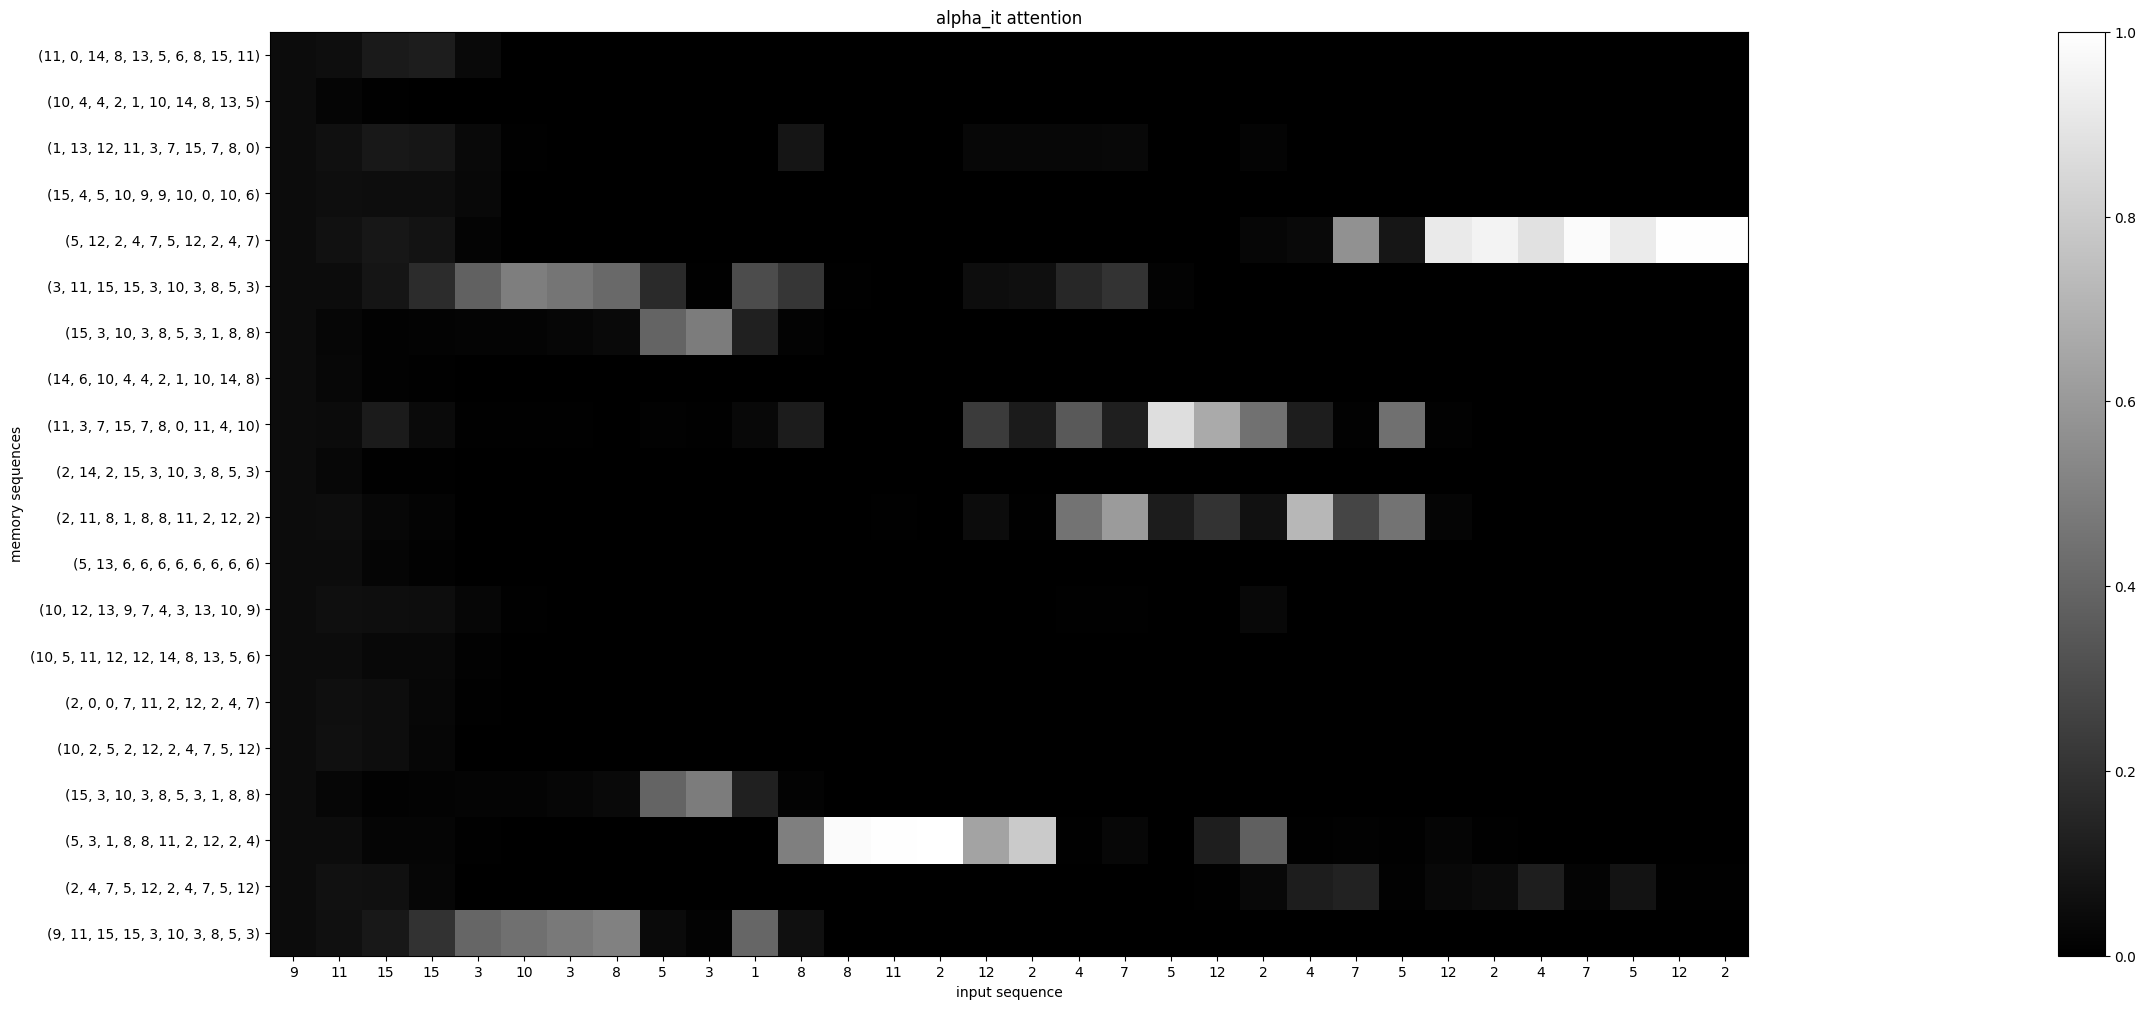

In [27]:
idx = np.random.choice(len(seqs_x_test)) 
print('kernel_model_cross_y2')

plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_test, mem_seqs_y_test, kernel_model_cross_y2)


100%|██████████| 6/6 [00:15<00:00,  2.61s/it]


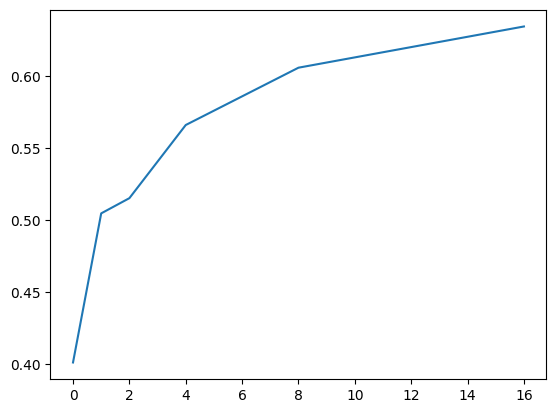

In [28]:
accs = []
nums_subseqs = [0, 1, 2, 4, 8, 16]
for num_subseqs in tqdm(nums_subseqs):
    seqs_x_test_, seqs_y_test_, mem_seqs_x_test_, mem_seqs_y_test_, sampled_test_mcs_ = sample_seqs_dataset(
        500, input_seq_len, mem_seq_len, mem_size, train_mcs, num_subseq_insertions=num_subseqs)

    test_ds_ = tf.data.Dataset.from_tensor_slices(((seqs_x_test_, mem_seqs_x_test_), seqs_y_test_)).batch(64)
    _, acc = kernel_model_cross_y2.evaluate(test_ds_, verbose=0)
    accs.append(acc)

plt.plot(nums_subseqs, accs)